# Metrics Visualizations

In [1]:
from Data.data_dicts import character_dict, source_dict, random_state

characters = ['Barney' , 'Sheldon' , 'Harry' , 'Fry' , 'Vader' , 'Joey' , 'Phoebe' , 'Bender']

In [2]:
# Mount google drive
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    base_folder = '/content/drive/My Drive/unibo/NLP_project/BarneyBot'
    os.system("pip install datasets")
    os.system("pip install transformers")
    os.system("pip install rouge_score")
    os.system("pip install -U sentence-transformers")
else:
    base_folder = os.getcwd()

in_metrics_folder = os.path.join(base_folder, 'Metrics')
if not os.path.exists(in_metrics_folder):
    os.makedirs(in_metrics_folder)
    
out_metricsPlot_folder = os.path.join(base_folder, 'Metrics', 'Plots')
if not os.path.exists(out_metricsPlot_folder):
    os.makedirs(out_metricsPlot_folder)

In [3]:
import pandas as pd
import tensorflow as tf
import json
import numpy as np
import time
import scipy as sp
from datasets import load_dataset, DatasetDict
from tqdm import tqdm 

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
from itertools import product as zip_cartesian
from Lib.BBRadar import BBRadar
import warnings
warnings.filterwarnings("ignore")

## Data plots

In [5]:
def load_df(character):
    dataset_path = os.path.join(base_folder, "Data", "Characters", character, character+'.csv')
    
    character_hg = load_dataset('csv', 
                                data_files=dataset_path, 
                                cache_dir=os.path.join(base_folder, "cache"))
    
    # 85% train / 10% test / 5% validation
    train_test_hg = character_hg['train'].train_test_split(test_size=0.15, seed=random_state)
    test_val = train_test_hg['test'].train_test_split(test_size=0.33, seed=random_state)
    
    
    character_hg = DatasetDict({
        'train': train_test_hg['train'],
        'test': test_val['train'],
        'val': test_val['test']
    })
    
    return character_hg

In [6]:
def plot_datasets(charList, characters_hg, colors=['red','orange','gold']):
    # number of characters
    n = len(charList)
    # number of sets for each character
    m = len(characters_hg[0])
    sets = [s for s in characters_hg[0]]
    # the xlabels are the name of characters
    xlabels = charList
    
    # extract lenght of each dataset
    data   = np.array([[len(characters_hg[c][s]) for c in range(n)] for s in sets])
    
    # plots the dataset
    fig, ax = plt.subplots(facecolor='white', figsize=(15, 10))
    for c in range(len(charList)):
        for hgdict, i in zip(characters_hg[c], range(n)):
            ax.bar(xlabels, data[i], 0.3, color=colors[i])
    ax.set_xlabel('Set')
    ax.set_ylabel('Number of lines')
    ax.set_title('Barplot of Dataset of all characters', fontweight="bold")
    ax.legend([hgdict for hgdict in characters_hg[0]])
    ax.grid(True)
    fig.savefig(os.path.join(out_metricsPlot_folder, 'Datasets characters'), dpi=fig.dpi)
    return None

In [25]:
def plot_metrics(metrics, title, c1, c2=None, cols=4, colors=None):
    colors = ['tab:blue', 'tab:orange', 'tab:orange', 'tab:red'] 
    metadata = metrics['metadata']
    metrics_size = len(metrics) + 1
    if not metrics_size % cols == 0:
        rows = metrics_size // cols + 1
    else:
        rows = metrics_size // cols
    
    fig = plt.figure(figsize=(20, 10), facecolor='white')
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.8)
    idx = 1
    
    # semantic similarity
    m = 'semantic similarity'
    data = []
    std  = []
    for s in metrics[m]:
        try:
            data.append(s['score'])
            std.append(s['std'])
        except:
            data.append(s)
            std.append(0)
    labels = metadata[m]['ordering']
    ax = fig.add_subplot(rows, cols, idx)
    ax.bar(labels, np.array(data), 0.3, yerr=std, color=colors)
    ax.set_title(m,fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xticklabels(metadata[m]['ordering'], rotation=25)
    ax.grid(True)
    idx += 1
    
    # bleu
    m = 'bleu'
    data = []
    std  = [0 for _ in range(len(metrics[m]))]
    for s in metrics[m]:
        try:
            data.append(s['score'])
        except:
            data.append(s)
    ax = fig.add_subplot(rows, cols, idx)
    ax.bar(metadata[m]['ordering'], np.array(data), 0.3, yerr=std, color=colors)
    ax.set_title(m,fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xticklabels(metadata[m]['ordering'], rotation=25)
    ax.grid(True)
    idx += 1
    
    # rouge l
    m = 'rouge l'
    data = []
    std  = []
    for s in metrics[m]:
        try:
            data.append(s['score'])
            std.append(s['std'])
        except:
            data.append(s)
            std.append(0)
    ax = fig.add_subplot(rows, cols, idx)
    ax.bar(metadata[m]['ordering'], np.array(data), 0.3, yerr=std, color=colors)
    ax.set_title(m,fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xticklabels(metadata[m]['ordering'], rotation=25)
    ax.grid(True)
    idx += 1
    
    # distinct
    m = 'distinct'
    data = []
    std  = []
    for s in metrics[m]:
        try:
            data.append(s['score'])
            std.append(s['std'])
        except:
            data.append(s)
            std.append(0)
    ax = fig.add_subplot(rows, cols, idx)
    ax.bar(metadata[m]['ordering'], np.array(data), 0.3, yerr=std, color=colors)
    ax.set_title(m,fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xticklabels(metadata[m]['ordering'],rotation=25)
    ax.grid(True)
    idx += 1

    # perplexity
    m = 'perplexity'
    try:
        ax = fig.add_subplot(rows, cols, idx)
        ax.axis('off')
        if isinstance(metrics[m], list):
            ax.text(0.5, 0.25, metadata[m]['ordering'][1] + ' ' + str(np.round(metrics[m][1], decimals=2)), 
                    fontweight='bold', size=18, ha='center', va='center', color=colors[0])
            ax.text(0.5, 0.75, metadata[m]['ordering'][0] + ' ' + str(np.round(metrics[m][0], decimals=2)), 
                    fontweight='bold', size=18, ha='center', va='center', color=colors[1])
        else:
            ax.text(0.5, 0.5, str(np.round(metrics[m], decimals=2)), fontweight='bold', 
                    size=35, ha='center', va='center', color=colors[1])
        ax.set_title(m, fontweight="bold")
        idx += 1
    except:
        pass
    
    # emotion
    m = 'emotion'
    data = []
    std  = []
    for s in metrics[m]:
        try:
            data.append(s['score'])
            std.append(s['std'])
        except:
            data.append(s)
            std.append(0) 
    labels = metrics[m][0]['label']
    ordering = metadata[m]['ordering']
    # 0 - context, 1 - label, 2 - chatbot 
    radar = BBRadar(labels, data[0], data[1], ordering[0]) # context
    radar.subplotEmotionsRadar(rows, cols, fig, idx, legend=ordering[0].split('-'), 
                               colors=['tab:orange', 'tab:blue'])
    idx +=1
    radar = BBRadar(labels, data[0], data[2], ordering[1]) # label 
    radar.subplotEmotionsRadar(rows, cols, fig, idx, legend=ordering[1].split('-'), 
                               colors=['tab:orange', 'tab:blue'])
    idx +=1
    radar = BBRadar(labels, data[2], data[1], ordering[2]) # chatbot
    radar.subplotEmotionsRadar(rows, cols, fig, idx, legend=ordering[2].split('-'), 
                               colors=['tab:orange', 'tab:blue'])
    idx +=1
    ### emotion pearson correlation
    ax = fig.add_subplot(rows, cols, idx)
    ax.barh(np.array([0.5]), 1, 0.5, color='white', edgecolor='black', linewidth=2)
    ax.set_title(m + ' pearson correlation',fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xlim([-0.1,1.1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([-1, 0, 1])
    ax.set_yticklabels([], rotation=25)
    ax.axvline(x=data[3], ymin=0.2, ymax=0.8, color=colors[1], lw=2)
    ax.grid(True)
    idx += 1
    
    # semantic answer similarity
    m = 'semantic answer similarity'
    data = []
    std  = []
    for s in metrics[m]:
        try:
            data.append(s['score'])
            std.append(s['std'])
        except:
            data.append(s)
            std.append(0)
    ax = fig.add_subplot(rows, cols, idx)
    ax.bar(metadata[m]['ordering'], np.array(data), 0.3, yerr=std, color=colors)
    ax.set_title(m,fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xticklabels(metadata[m]['ordering'], rotation=25)
    ax.grid(True)
    idx += 1
    
    # semantic classifier
    m = 'semantic classifier'
    data = []
    std  = []
    for s in metrics[m]:
        data.append(s['score'])
        std.append(s['std'])
    ax = fig.add_subplot(rows, cols, idx)
    labels = metadata[m]['ordering']
    ax.bar(labels, np.array(data), 0.3, yerr=std, color=['tab:orange', 'tab:blue'])
    ax.set_title(m,fontweight="bold")
    ax.set_ylim([0,1])
    ax.set_xticklabels(labels, rotation=25)
    ax.grid(True)
    idx += 1
    
    # set title
    fig.text(0.2, 0.965, title, horizontalalignment='center', color='black', weight='bold',
             size=22)
    fig.savefig(os.path.join(out_metricsPlot_folder, title), dpi=fig.dpi)
    return None

In [8]:
def read_metric(metric_path):
    if os.path.exists(metric_path):
        with open(metric_path, 'r') as file:
            json_string = file.read()
        metrics = json.loads(json_string)
        return metrics
    else:
        raise Exception("Loading " + metric_path + " failed!")

# Plots and save results

In [9]:
def plotMetricsChars(charList):
    os.environ["HF_DATASETS_CACHE"] = os.path.join(base_folder, "cache")
    
    # loads all datasets
    characters_hg = [load_df(c) for c in charList]
    
    # plots datasets
    plot_datasets(charList, characters_hg)
    
    for c1_id in range(len(charList)):
        c1 = charList[c1_id]
        c1_hg = characters_hg[c1_id]
        print('### character', c1)
        
        
        # plots the metrics of base
        base_metrics_path          = os.path.join(base_folder, "Metrics", 
                                                  c1+'_base_metrics.json')
        base_metric = read_metric(base_metrics_path)
        plot_metrics(base_metric, "Metrics " + c1 + ' base', c1)
        

        # plots the metrics of the 3 search strategies
        base_metrics_sampling_path = os.path.join(base_folder, "Metrics", 
                                                  c1+'_sampling_comparison_metrics.json')
        base_metrics_sampling = read_metric(base_metrics_sampling_path)
        for search_strategy in ['greedy_vs_nbeams', 'greedy_vs_sampling', 'nbeams_vs_sampling']:
            plot_metrics(base_metrics_sampling[search_strategy], 
                         "Metrics " + c1 + ' search ' + search_strategy.replace('_', ' '),  c1)
        
        
        # plots the metrics c1 vs Not Fine Tuned
        c1_vs_nf_metrics_path = os.path.join(base_folder, "Metrics", 
                                             c1+'_vs_nonfinetuned_metrics.json')
        c1_vs_nf_metrics = read_metric(c1_vs_nf_metrics_path)
        plot_metrics(c1_vs_nf_metrics, "Metrics " + c1 + ' vs Not Finetuned', c1)
        
        
        for c2_id in tqdm(range(len(charList))):
            if c1_id != c2_id:
                c2 = charList[c2_id]
                c1_vs_c2_metrics_path = os.path.join(base_folder, "Metrics", 
                                                     c1+'_vs_'+c2+'_metrics.json')
                try:
                    # if the c1 vs c2 metrics file exists
                    c1_vs_c2_metrics = read_metric(c1_vs_c2_metrics_path)
                    # load the dataset for c2
                    c2_hg = characters_hg[c2_id]
                    # and plots the c1 vs c2 metrics
                    plot_metrics(c1_vs_c2_metrics, 'Metrics ' + c1 + ' vs ' + c2, c1, c2)
                except:
                    pass

Using custom data configuration default-849ec2d6fbec0f0b
Reusing dataset csv (C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-849ec2d6fbec0f0b\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-849ec2d6fbec0f0b\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-8ad033ed4cc93f6d.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-849ec2d6fbec0f0b\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-3c864a6af3ba81cb.arrow
Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-849ec2d6fbec0f0b\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-b86e8f84e70f33c9.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-849ec2d6fbec0f0b\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-e8ebf9443826d23e.arrow
Using custom data configuration default-fbb5da8195eeafdf

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-fbb5da8195eeafdf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-ed070a17f87583b0.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-fbb5da8195eeafdf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-8b13a1828c5f655c.arrow
Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-fbb5da8195eeafdf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-2b4e70bae7b548bf.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-fbb5da8195eeafdf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-9730e803e8838750.arrow
Using custom data configuration default-73c19285f1c3d426

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-73c19285f1c3d426\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-ae052e701000ad98.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-73c19285f1c3d426\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-5a8dd9722cb31f5c.arrow
Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-73c19285f1c3d426\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-8e9e82d23eaead20.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-73c19285f1c3d426\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-685da3b38890d535.arrow
Using custom data configuration default-d4221cbf7d7518c5

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-d4221cbf7d7518c5\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-55046ca91fdf91d4.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-d4221cbf7d7518c5\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-0108b48b858c2f3b.arrow
Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-d4221cbf7d7518c5\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-21de8552dc0d278b.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-d4221cbf7d7518c5\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-69bb5e868749565e.arrow
Using custom data configuration default-2f824af92a32e170

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-2f824af92a32e170\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-8fbb3853168550e2.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-2f824af92a32e170\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-6b42a192e674cf33.arrow
Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-2f824af92a32e170\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-63dd68f40a615387.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-2f824af92a32e170\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-3d801a9a2da48dc0.arrow
Using custom data configuration default-68b30ae742fa1d97

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-68b30ae742fa1d97\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-4f78d4b40bf451d2.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-68b30ae742fa1d97\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-f68f7b2f31fd1682.arrow
Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-68b30ae742fa1d97\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-908fe4da8bb7c13a.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-68b30ae742fa1d97\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-6032fbadce8a22bf.arrow
Using custom data configuration default-3f27c26b6430c91b

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-3f27c26b6430c91b\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-df219ab69112f7c3.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-3f27c26b6430c91b\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-c619558689b5c355.arrow
Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-3f27c26b6430c91b\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-8a187d79bcd58282.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-3f27c26b6430c91b\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-d508008e9c7fb206.arrow
Using custom data configuration default-60724a056fb0dfca

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-60724a056fb0dfca\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-2a1d65ea98ad4992.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-60724a056fb0dfca\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-9db242bf12dc7e2b.arrow
Loading cached split indices for dataset at C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-60724a056fb0dfca\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-78886baffbe57b8d.arrow and C:\Users\david\Documents\unibo\natural_language_processing\project\BarneyBot\cache\csv\default-60724a056fb0dfca\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-27907eee8c71bfef.arrow


### character Barney


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.72it/s]


### character Sheldon


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


### character Harry


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 7989.15it/s]


### character Fry


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 17.58it/s]


### character Vader


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.78it/s]


### character Joey


100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


### character Phoebe


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 17.41it/s]


### character Bender


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 7991.05it/s]


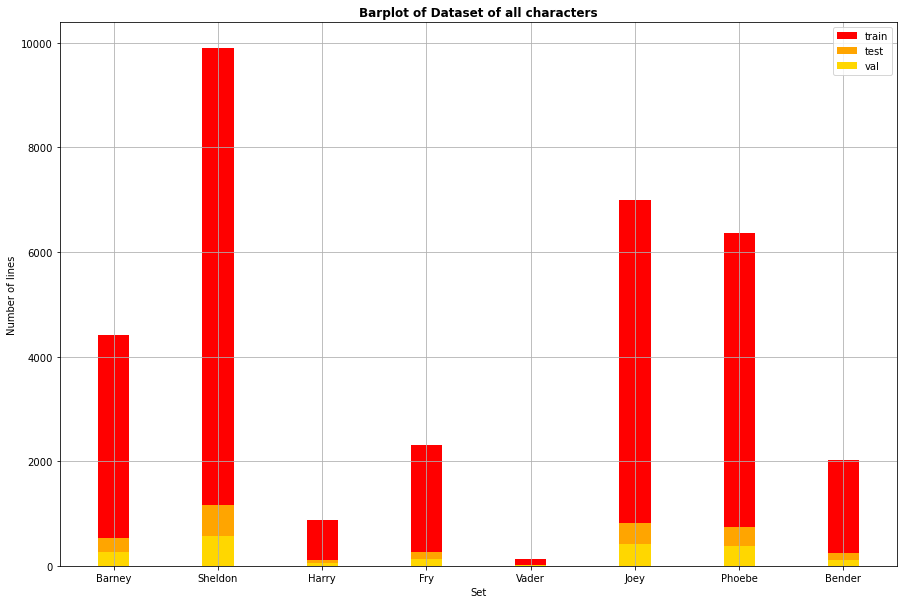

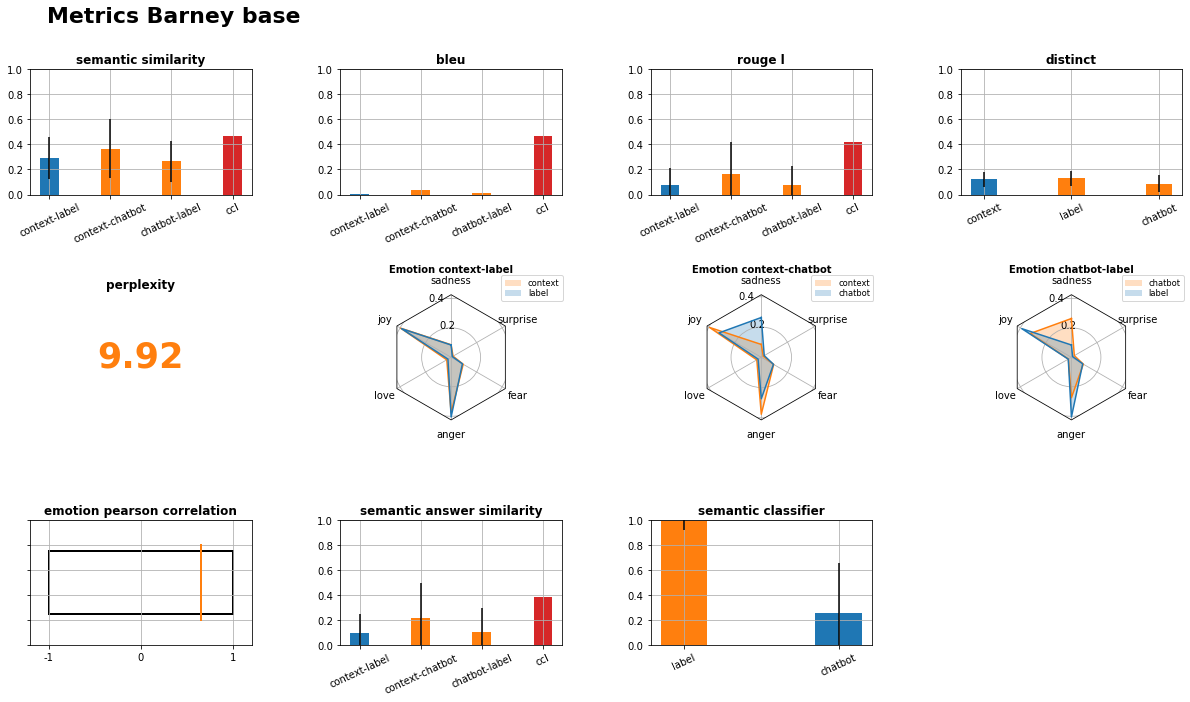

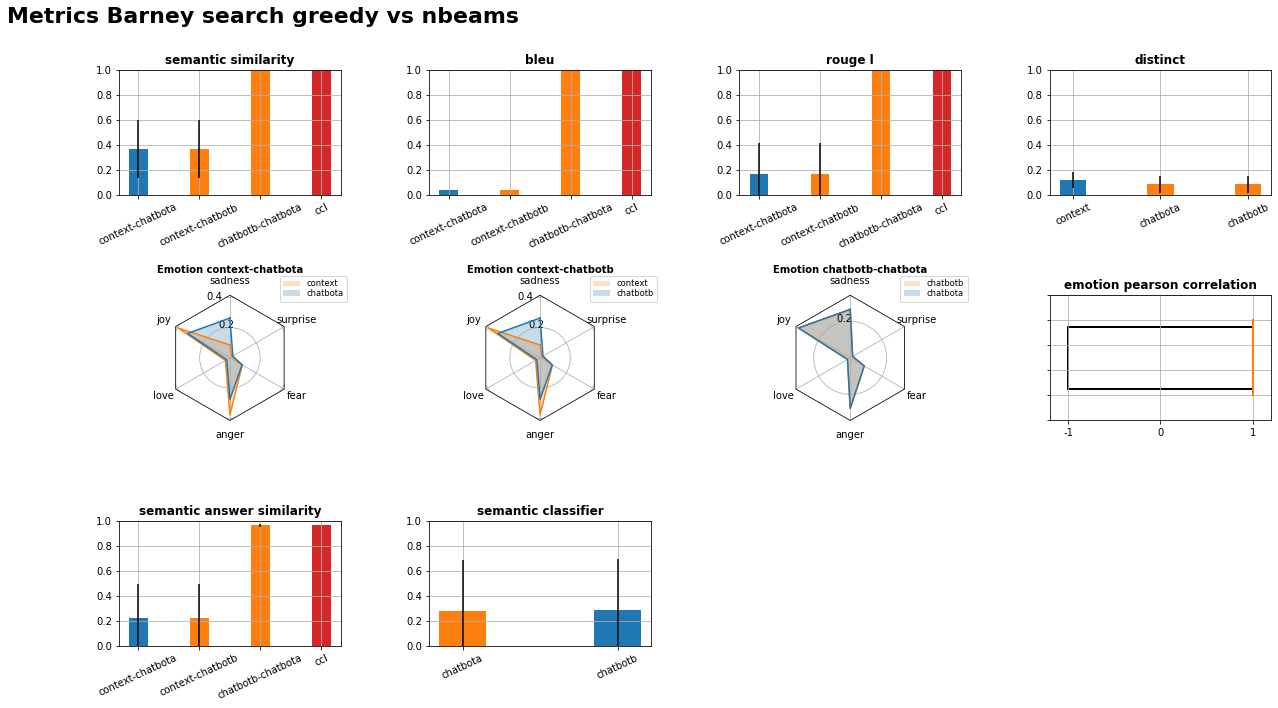

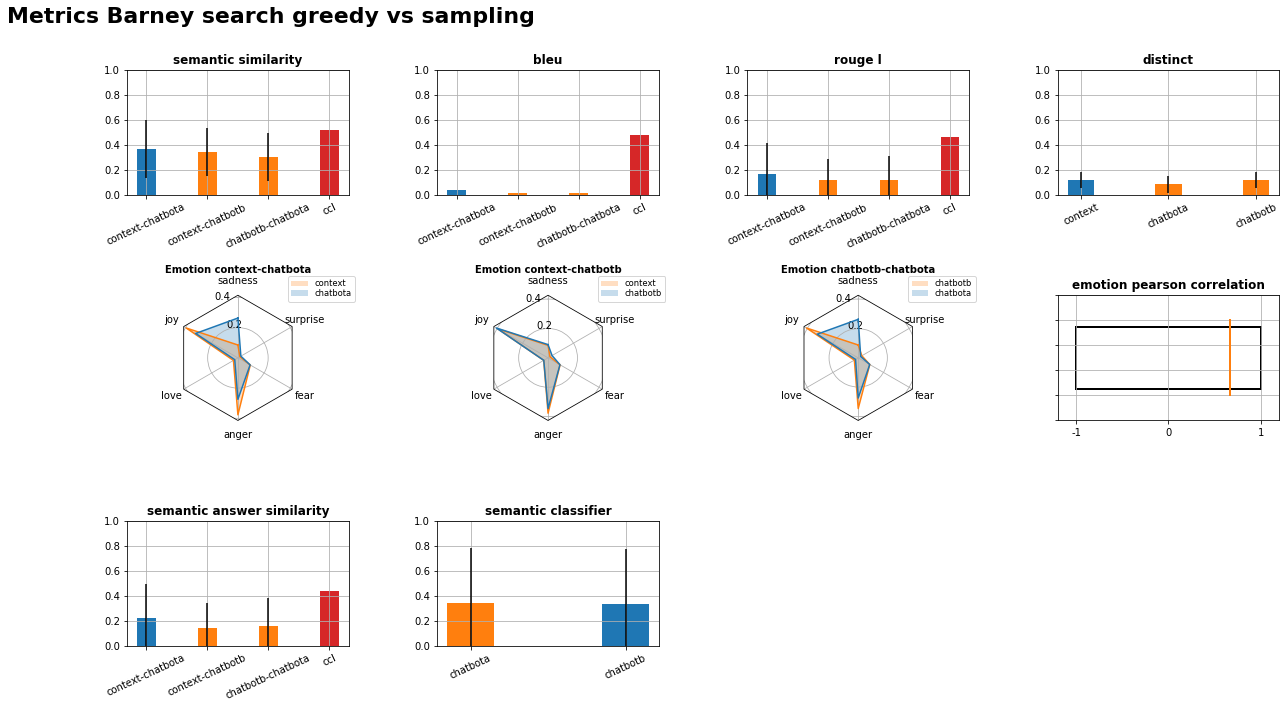

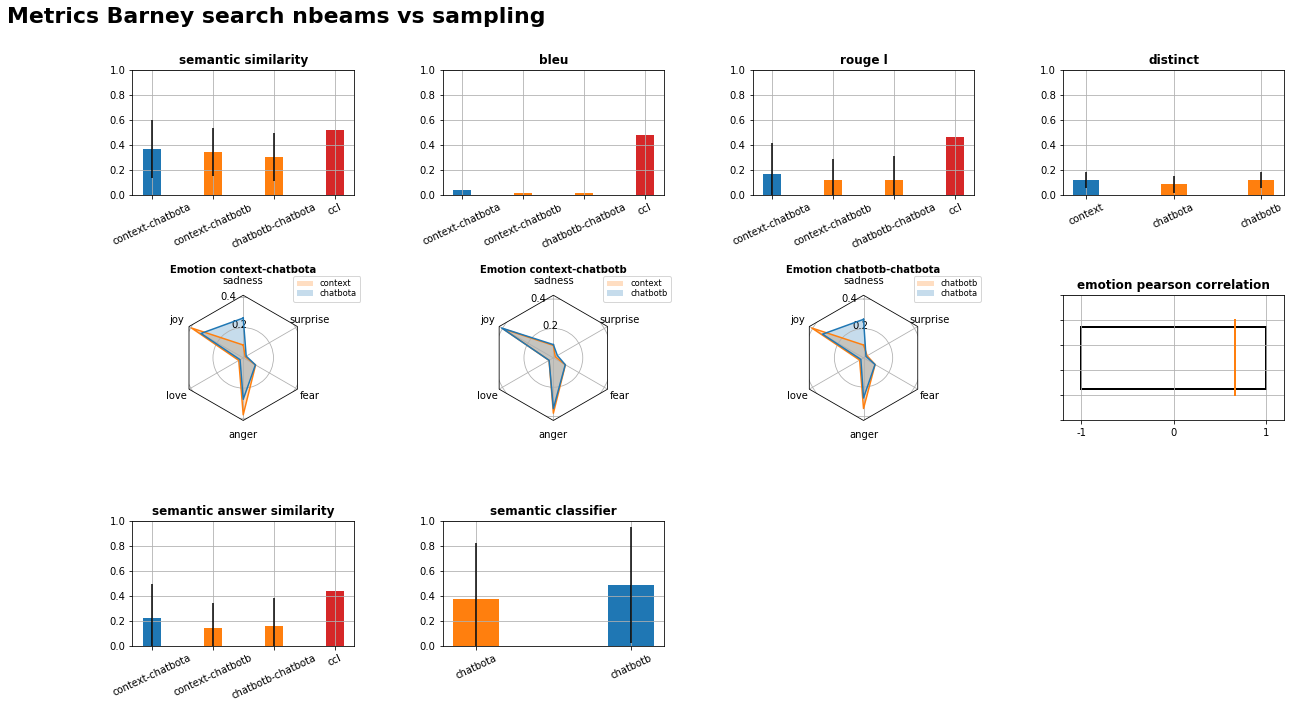

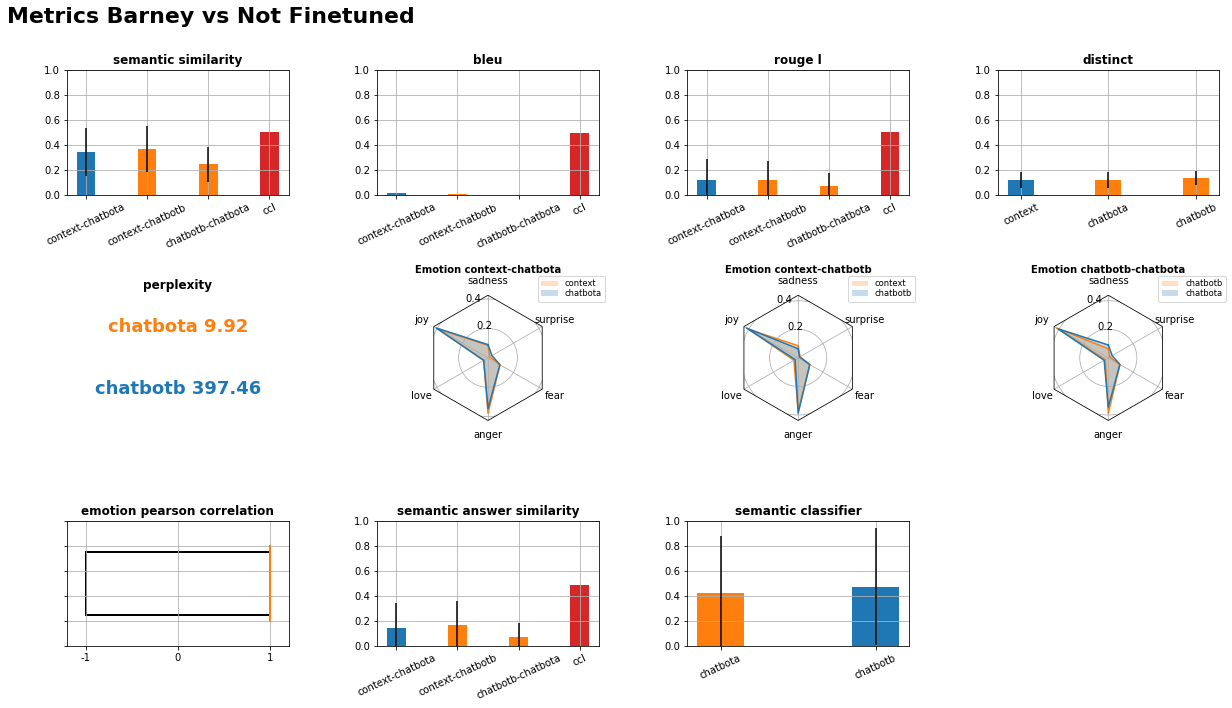

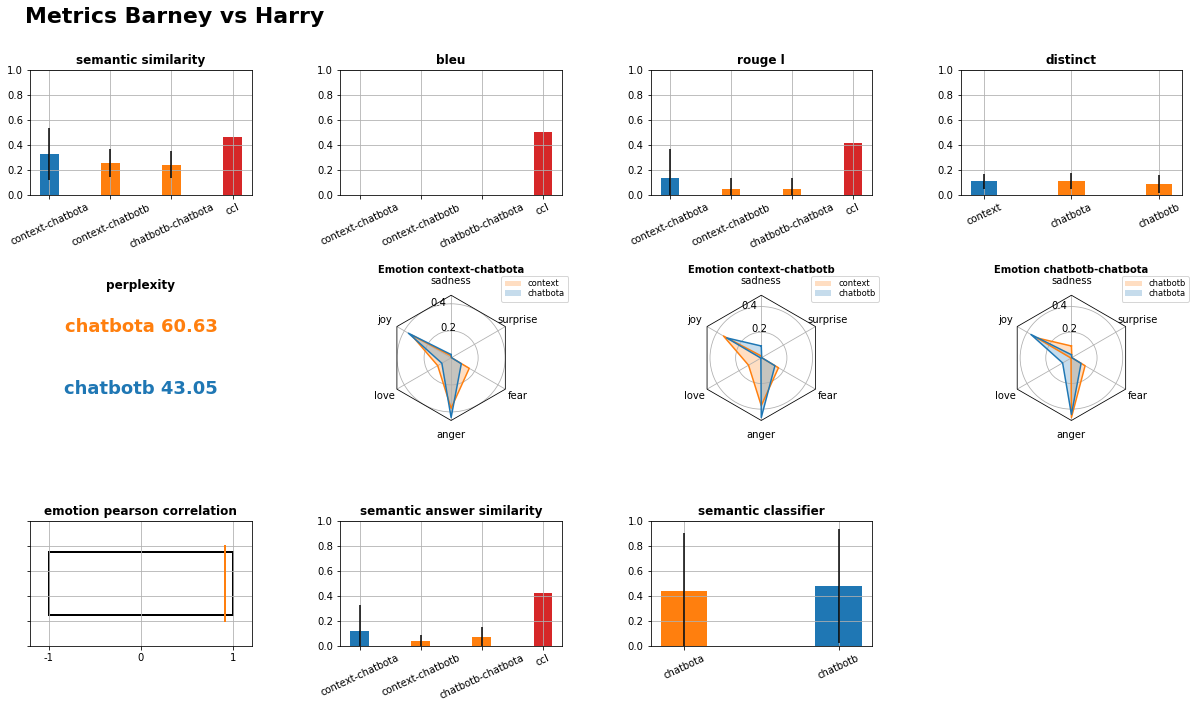

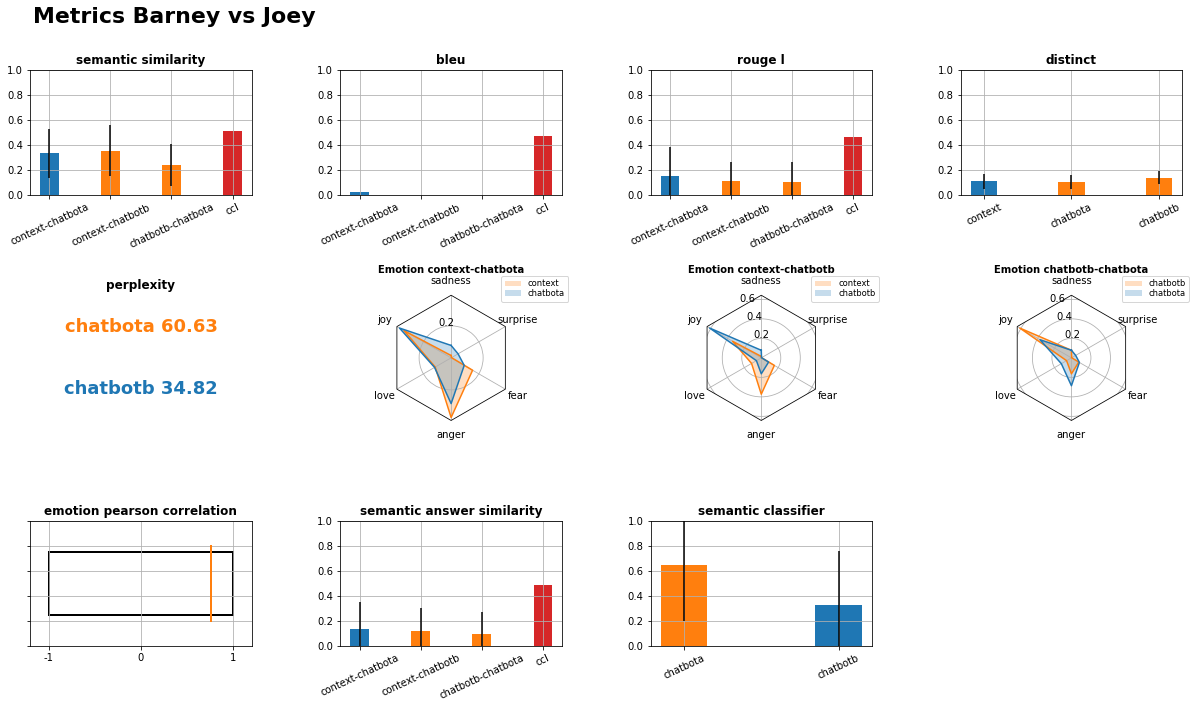

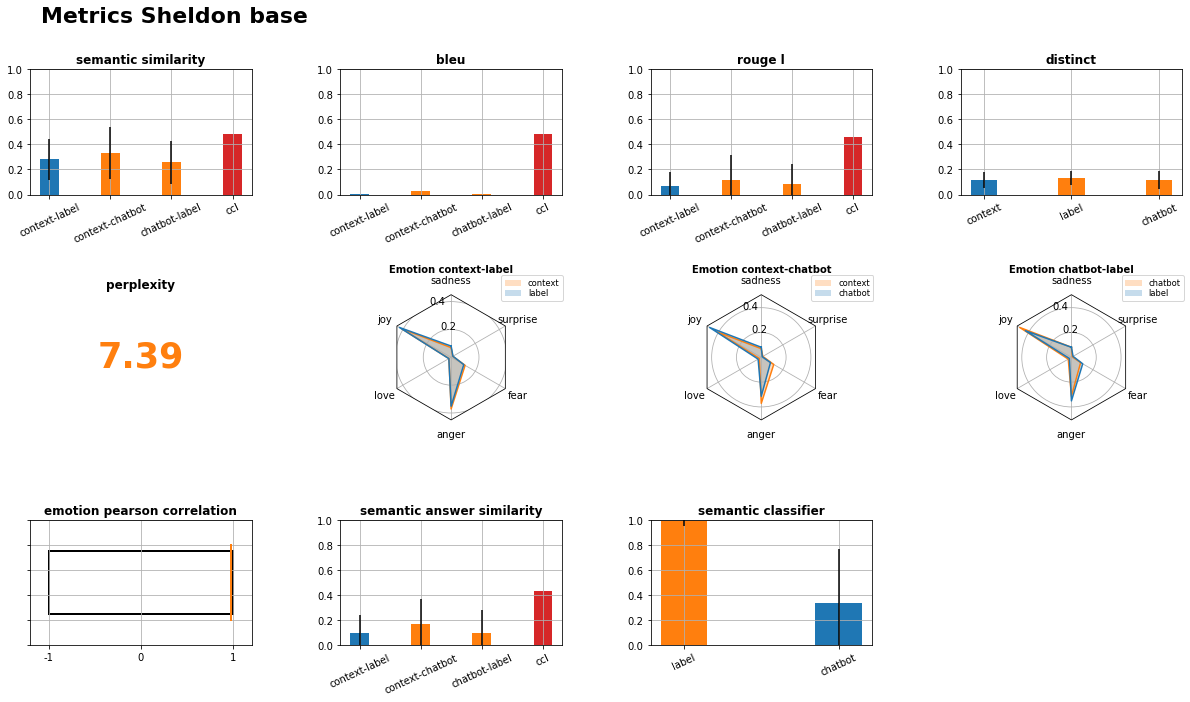

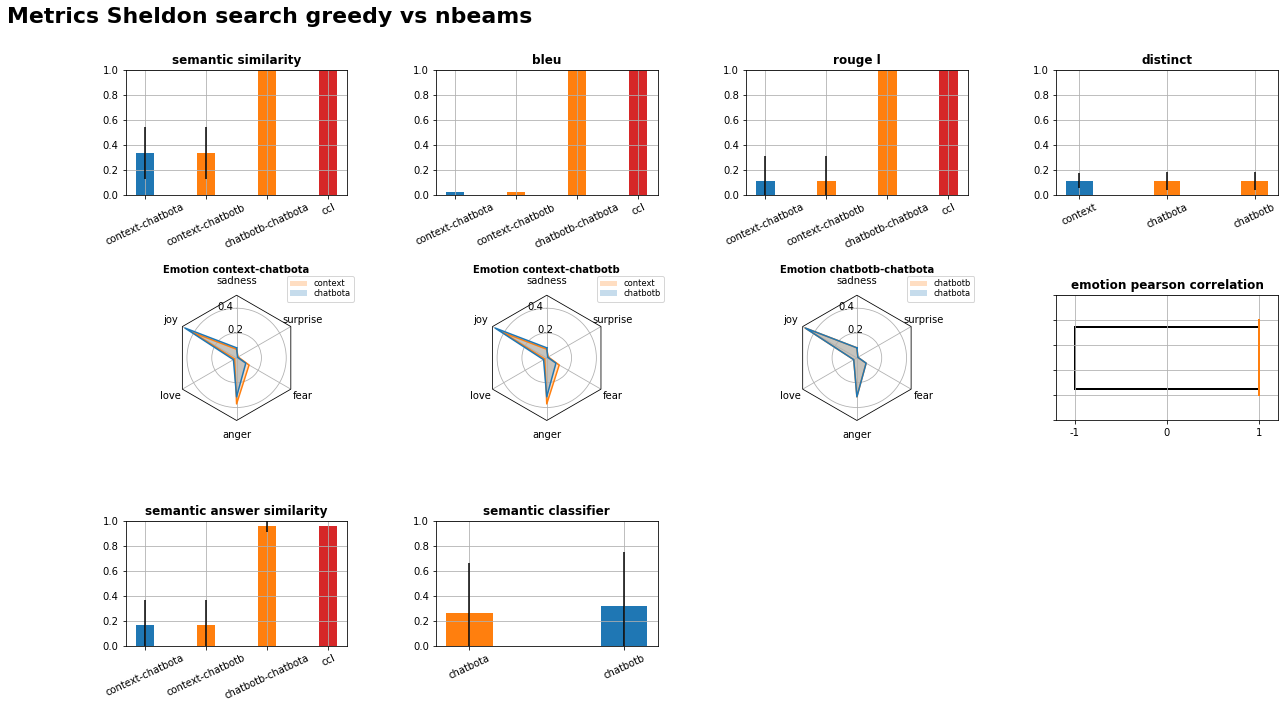

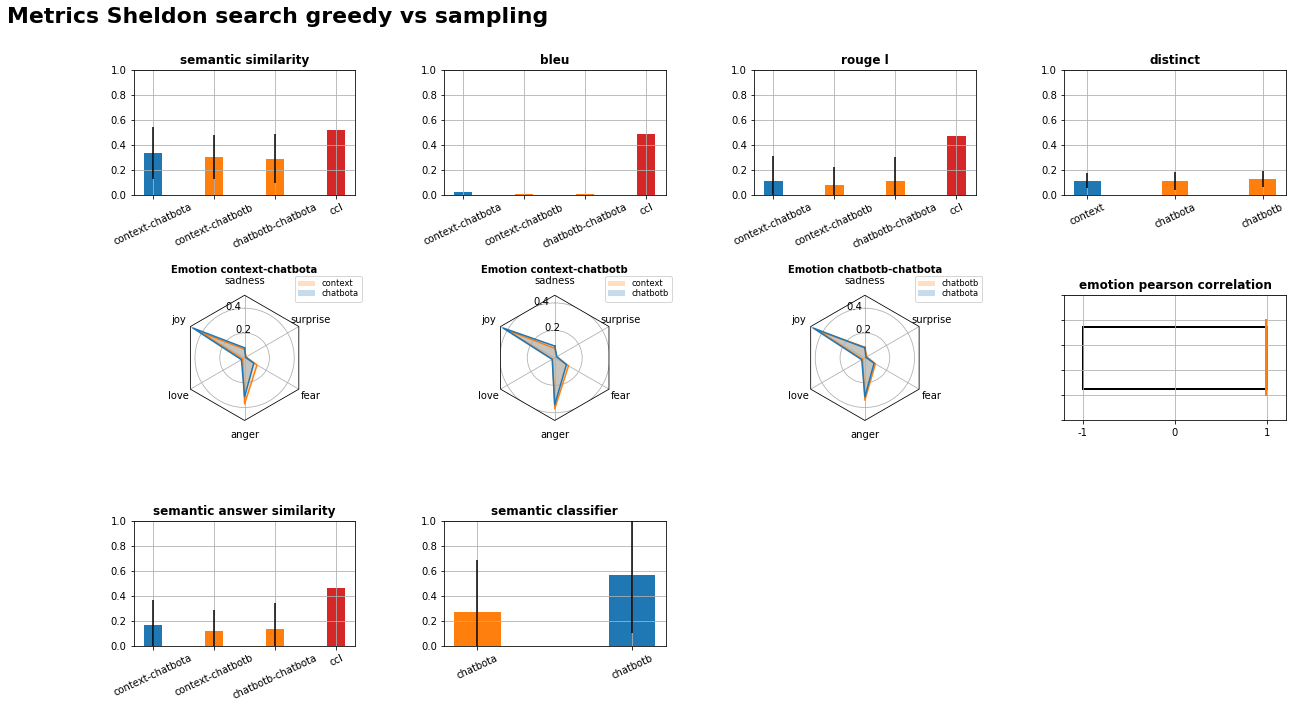

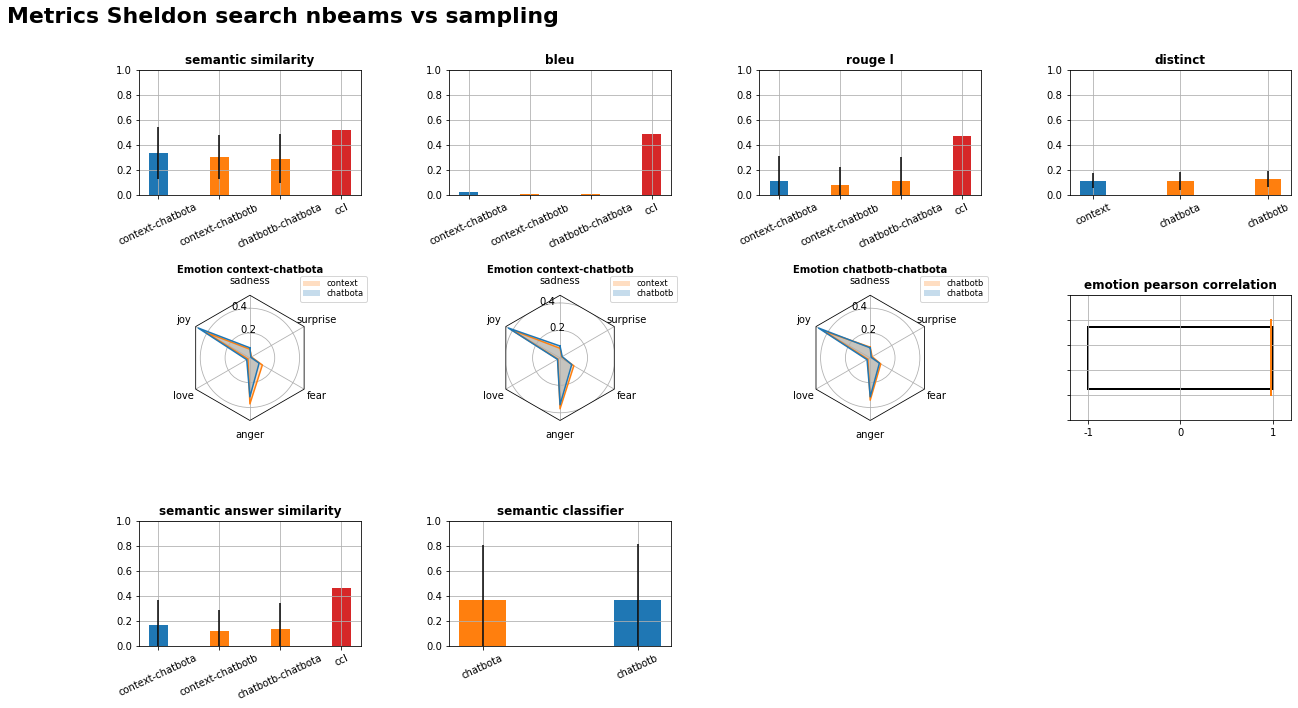

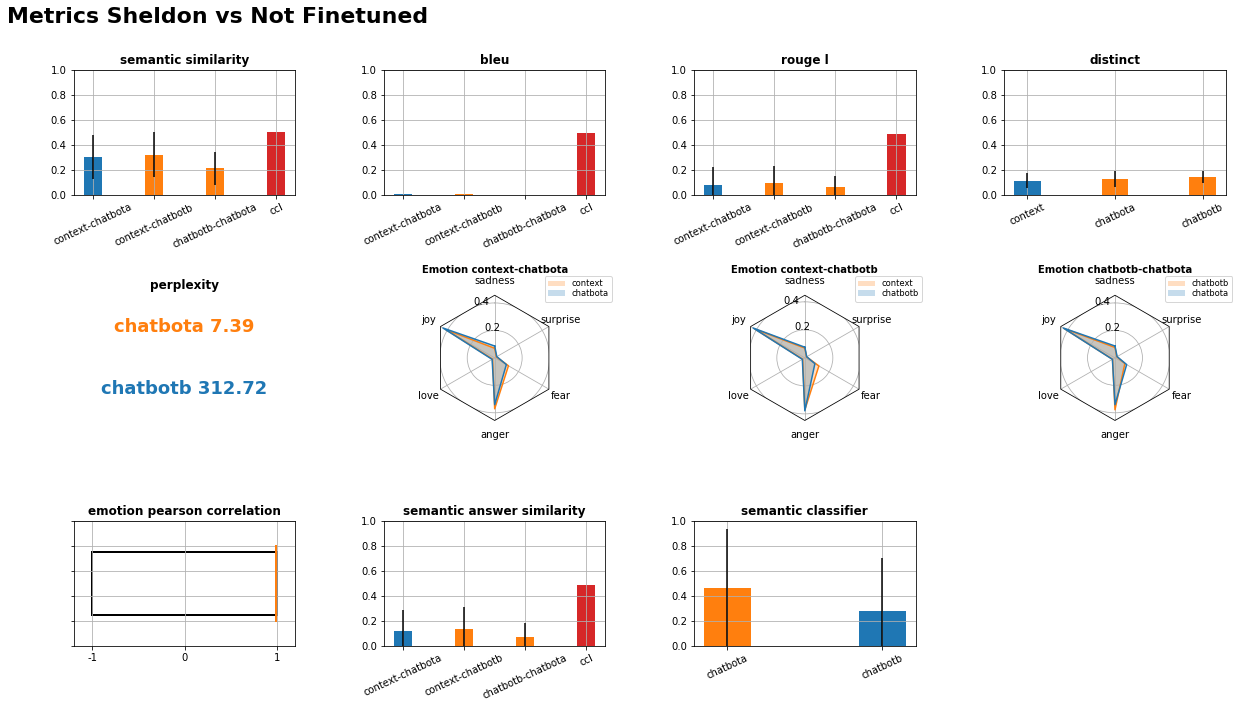

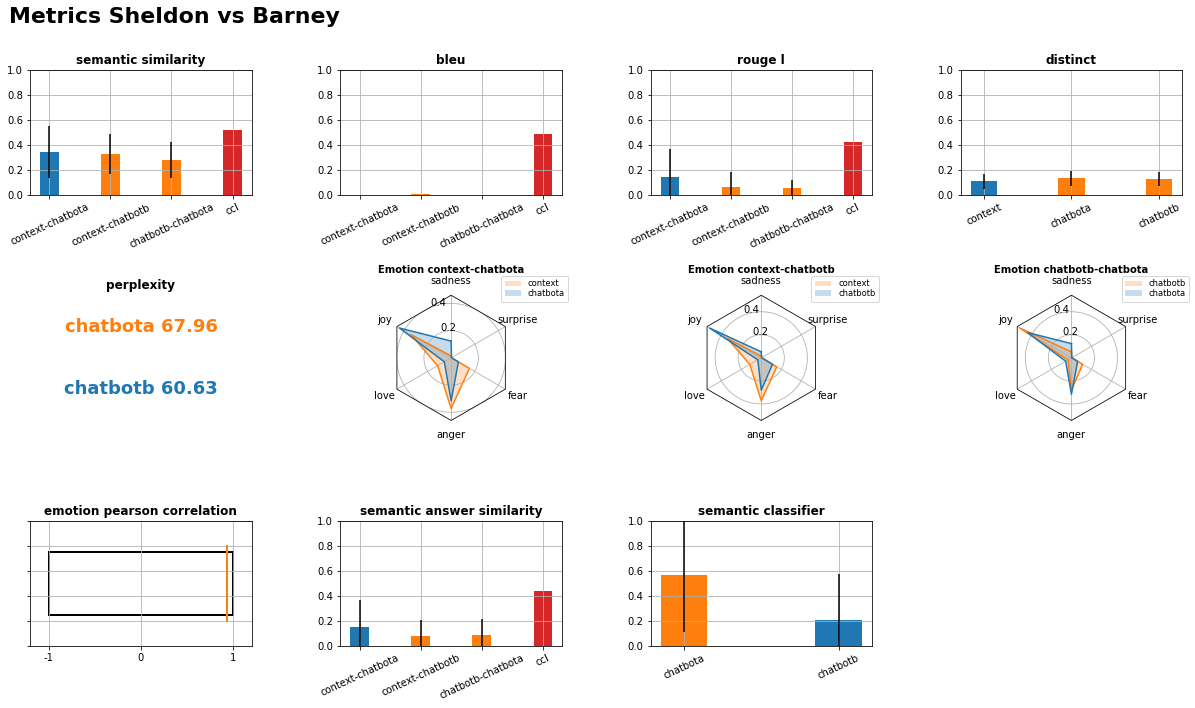

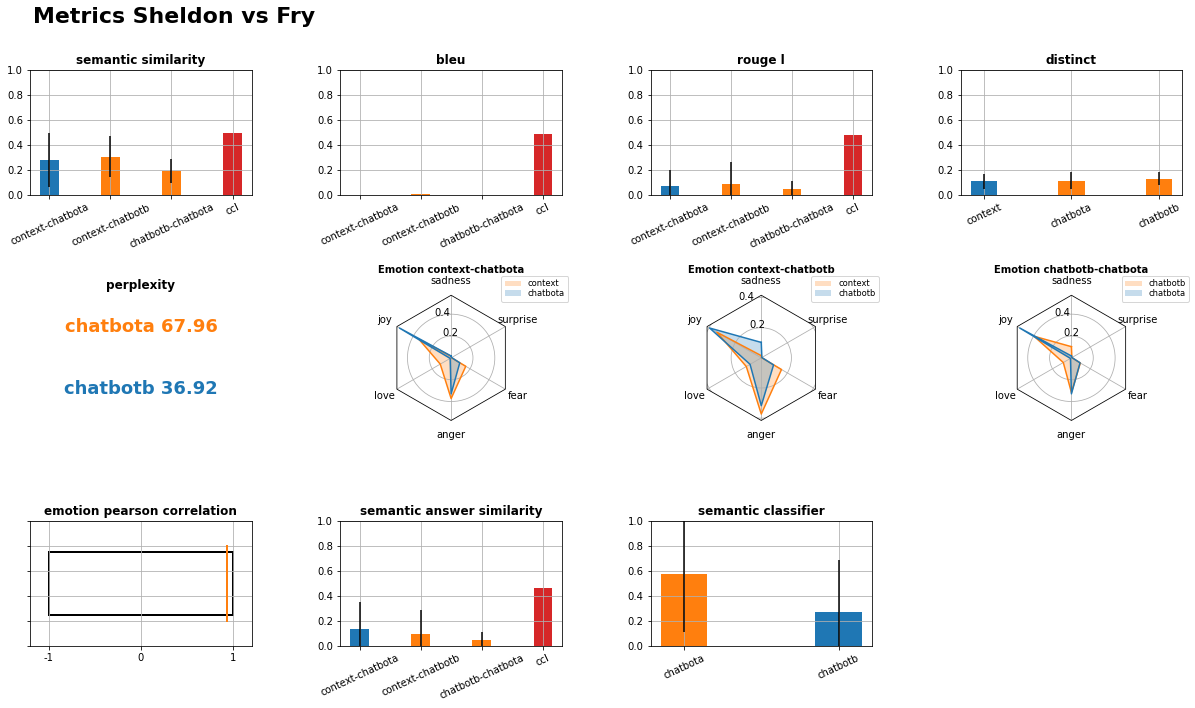

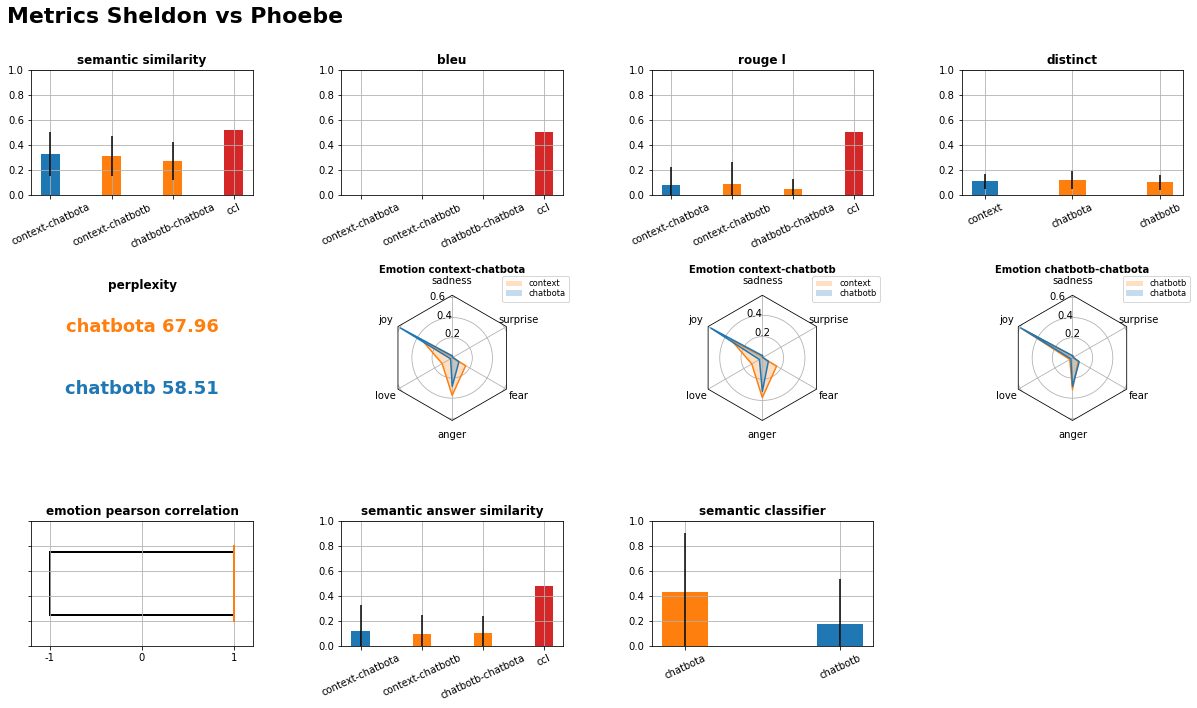

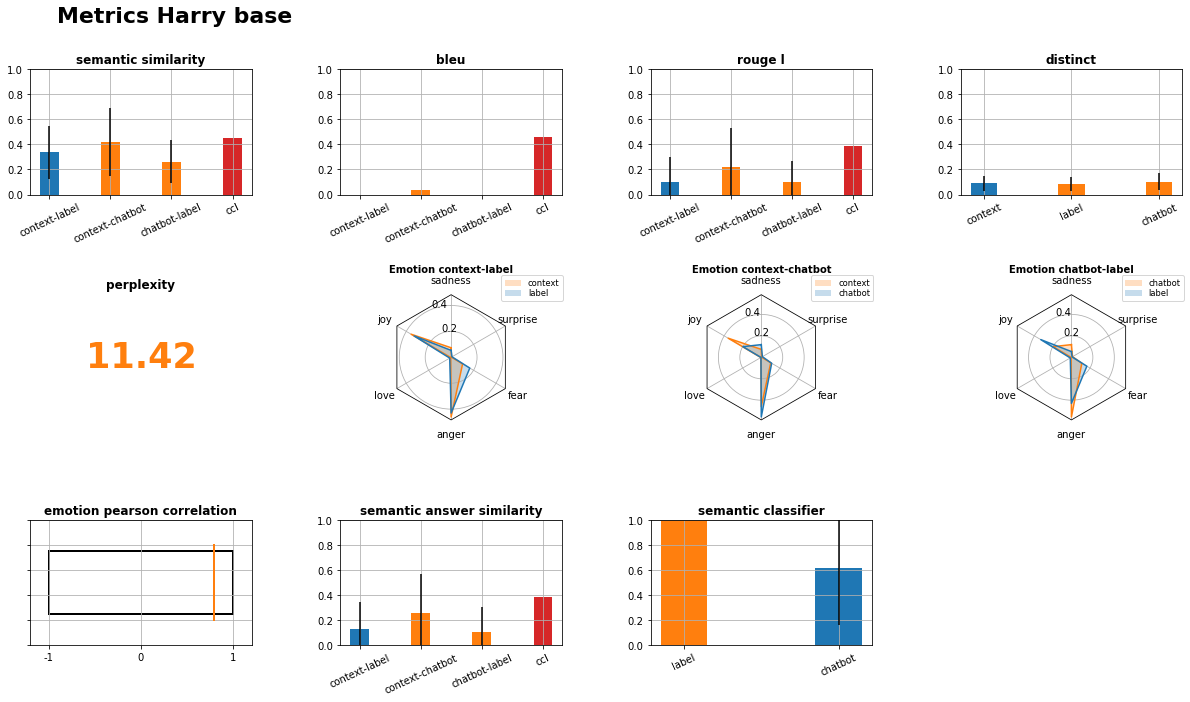

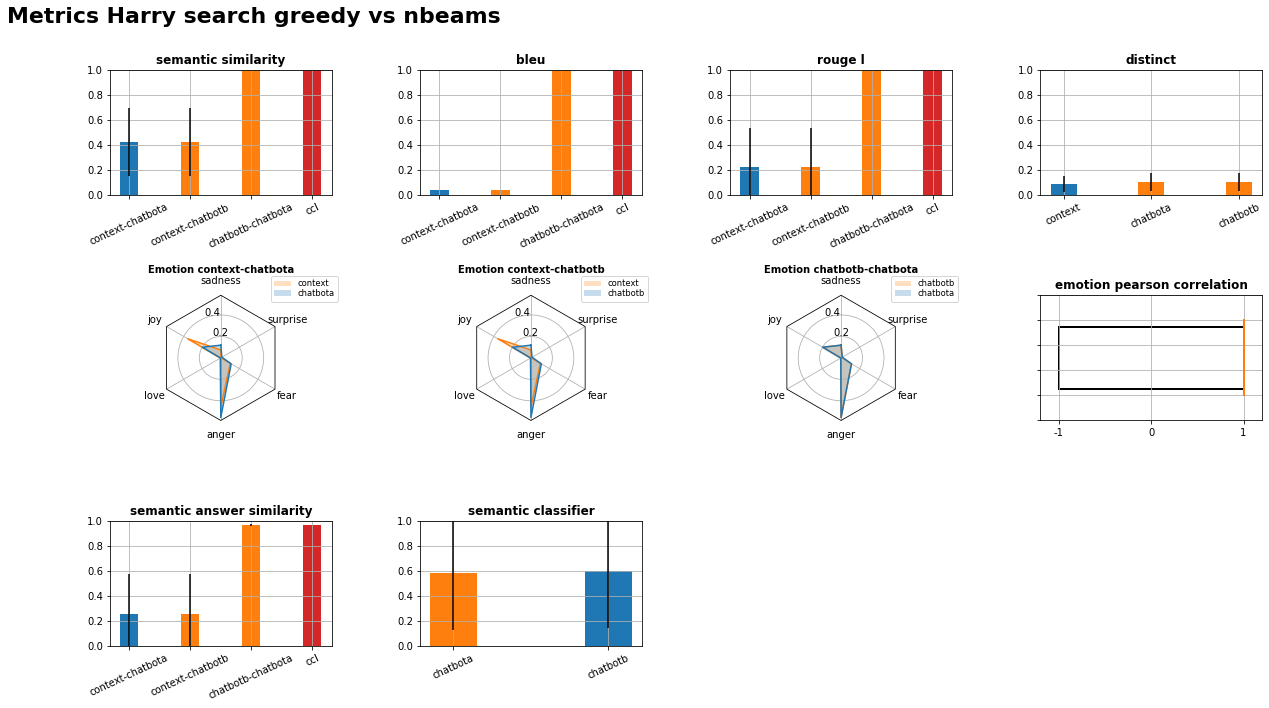

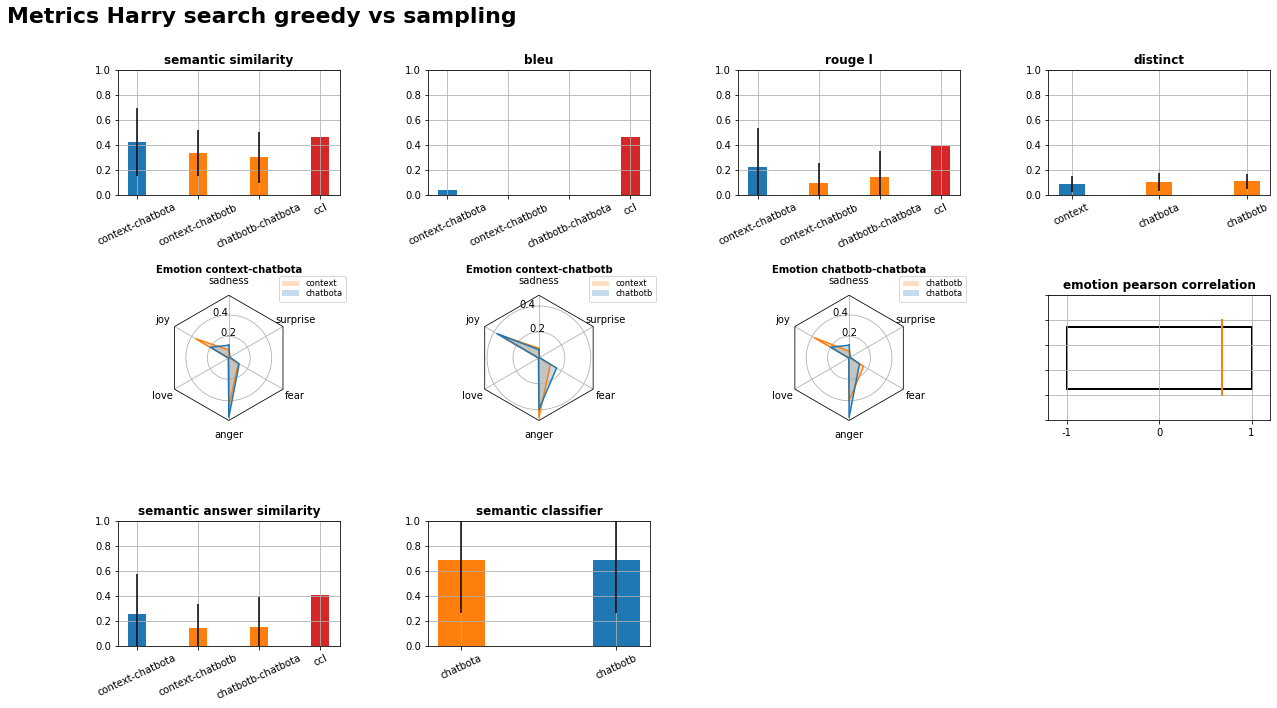

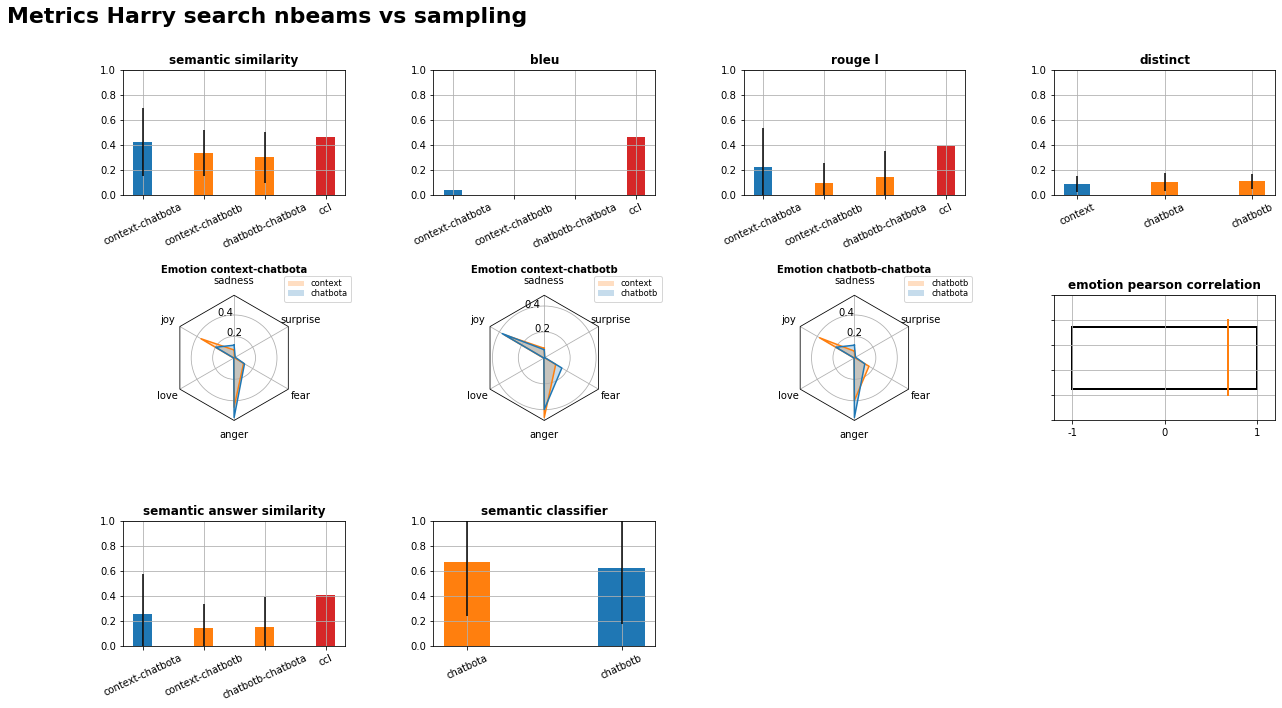

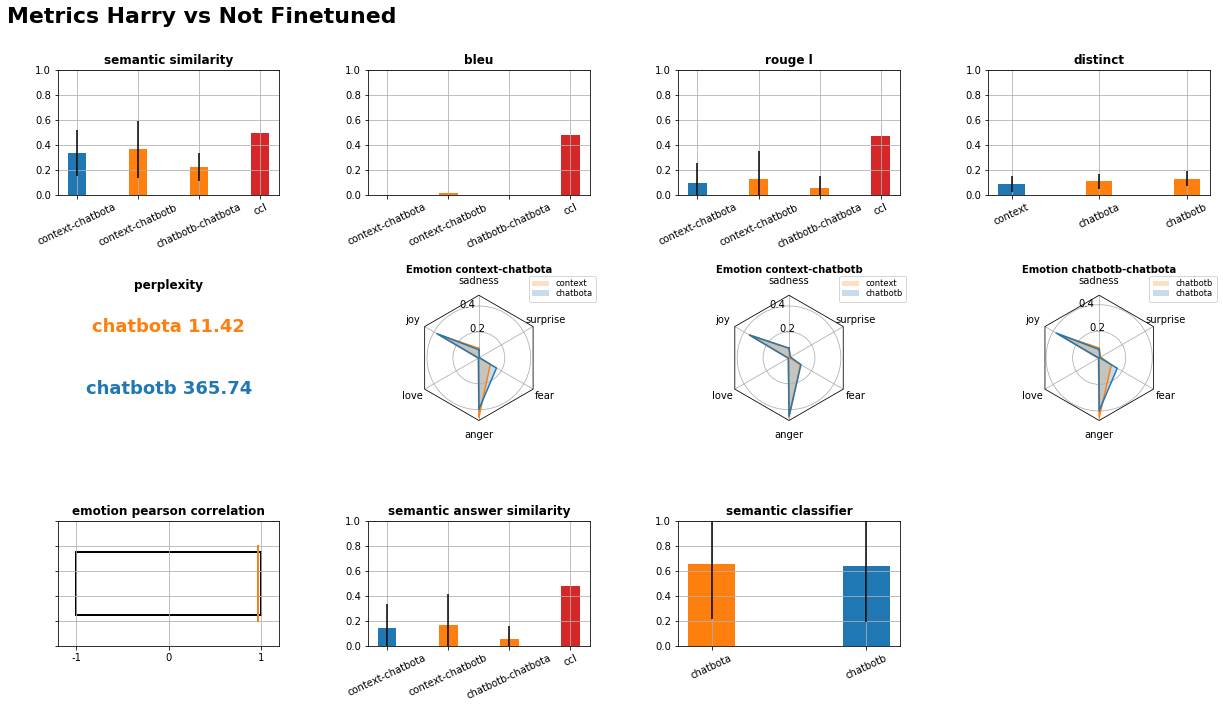

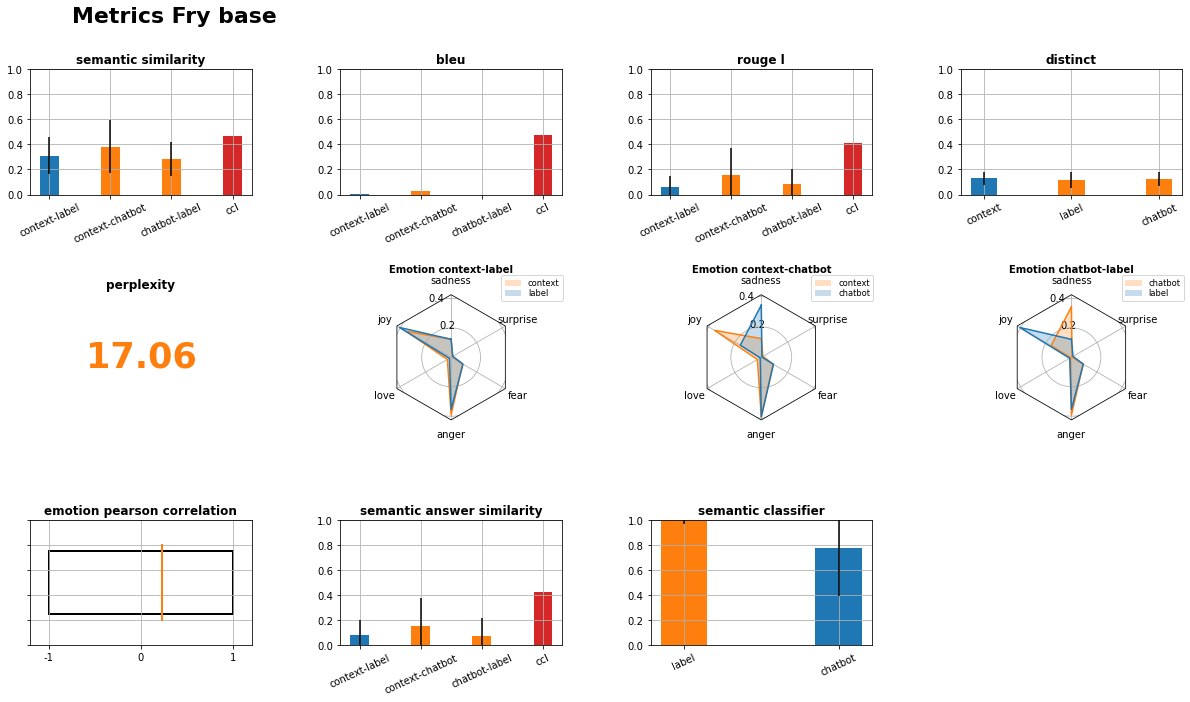

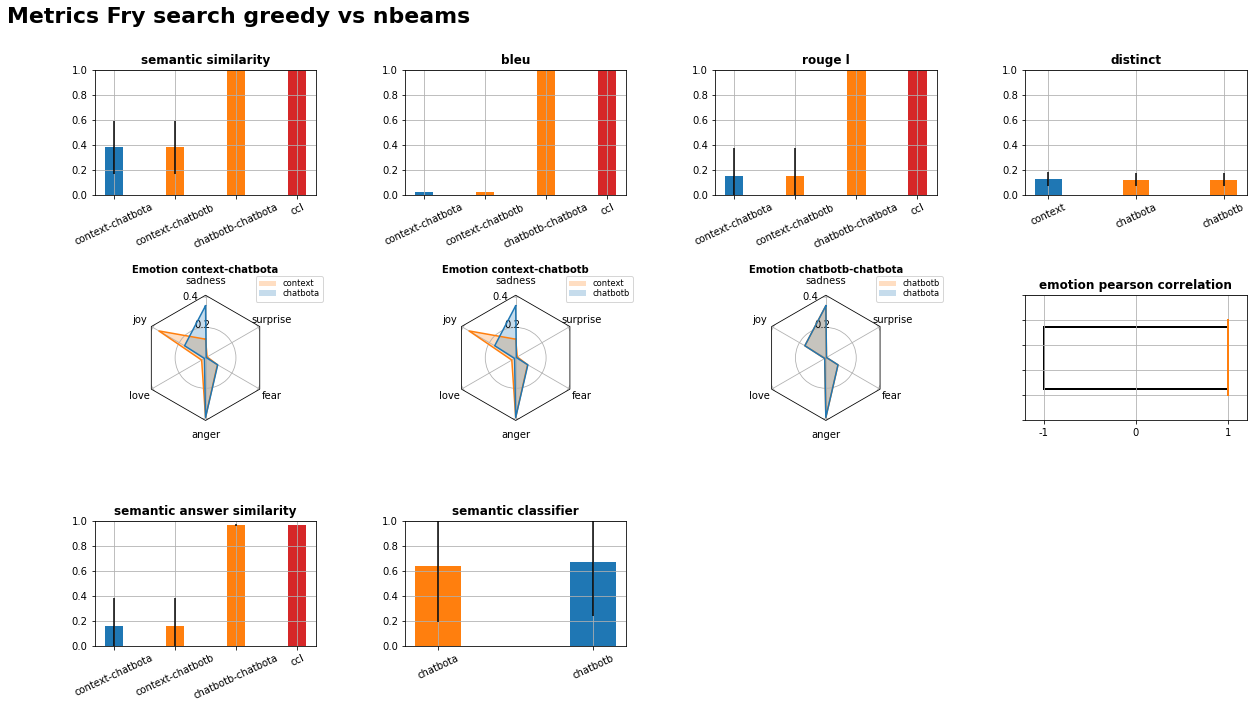

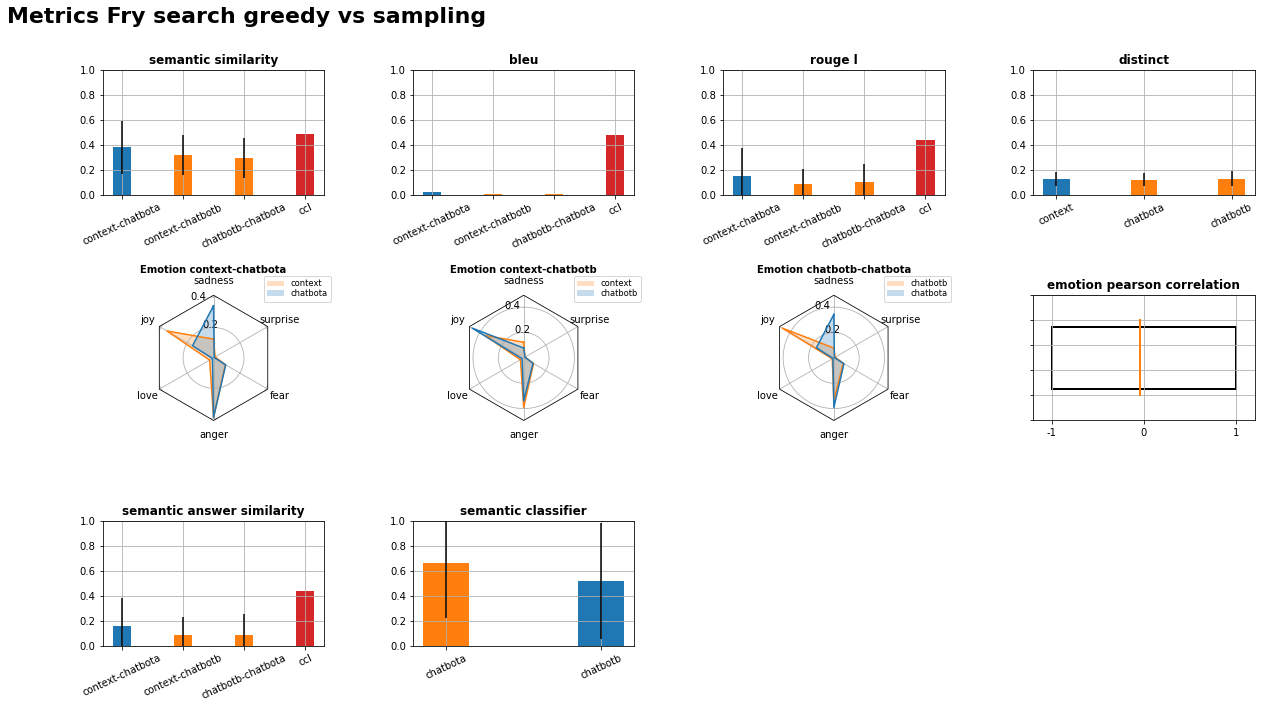

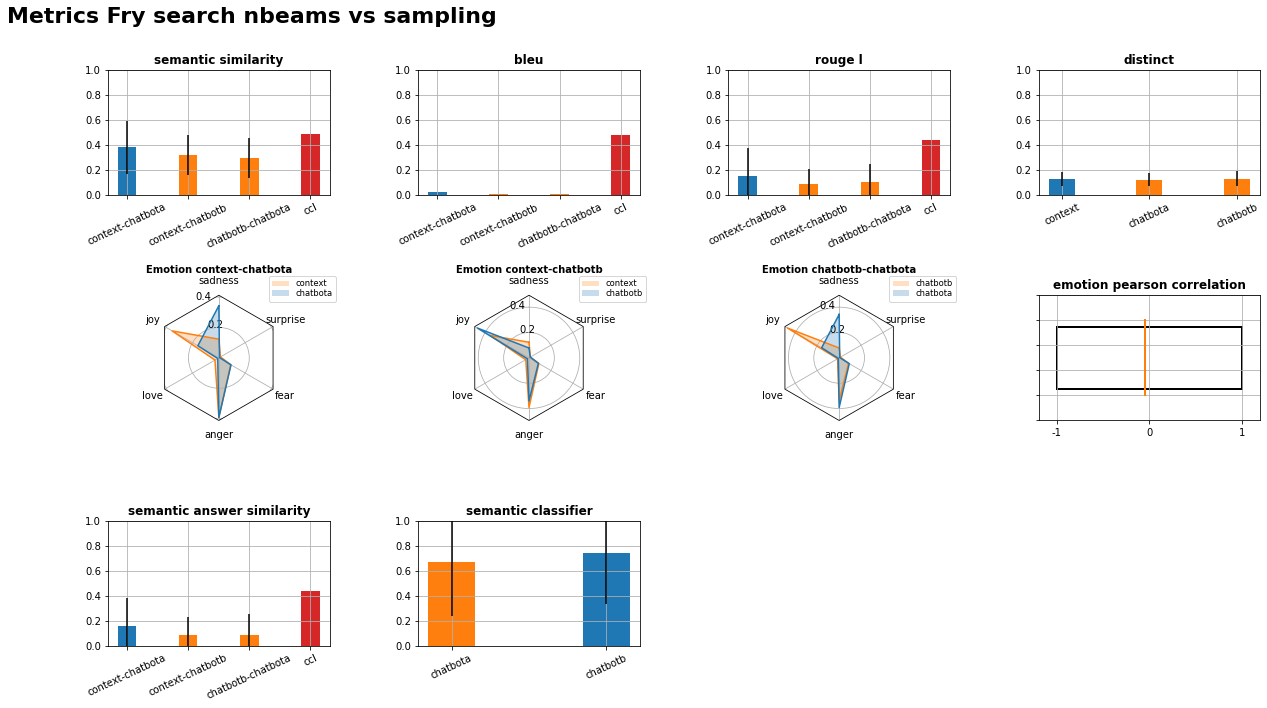

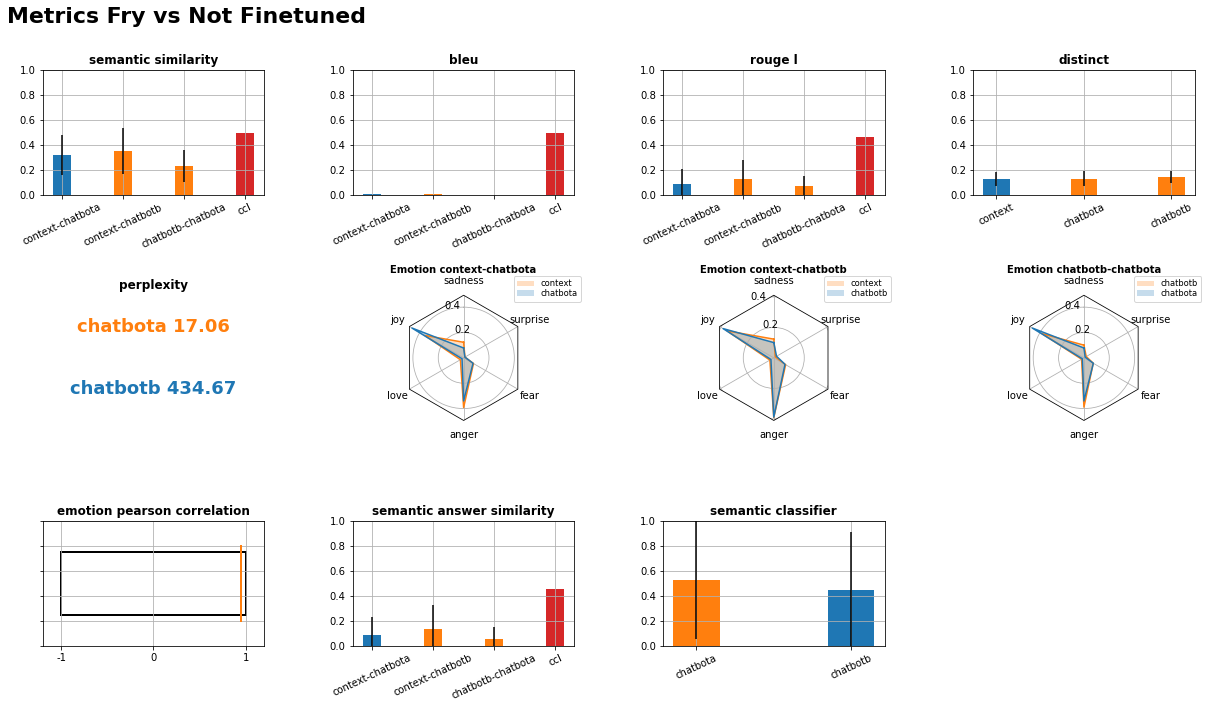

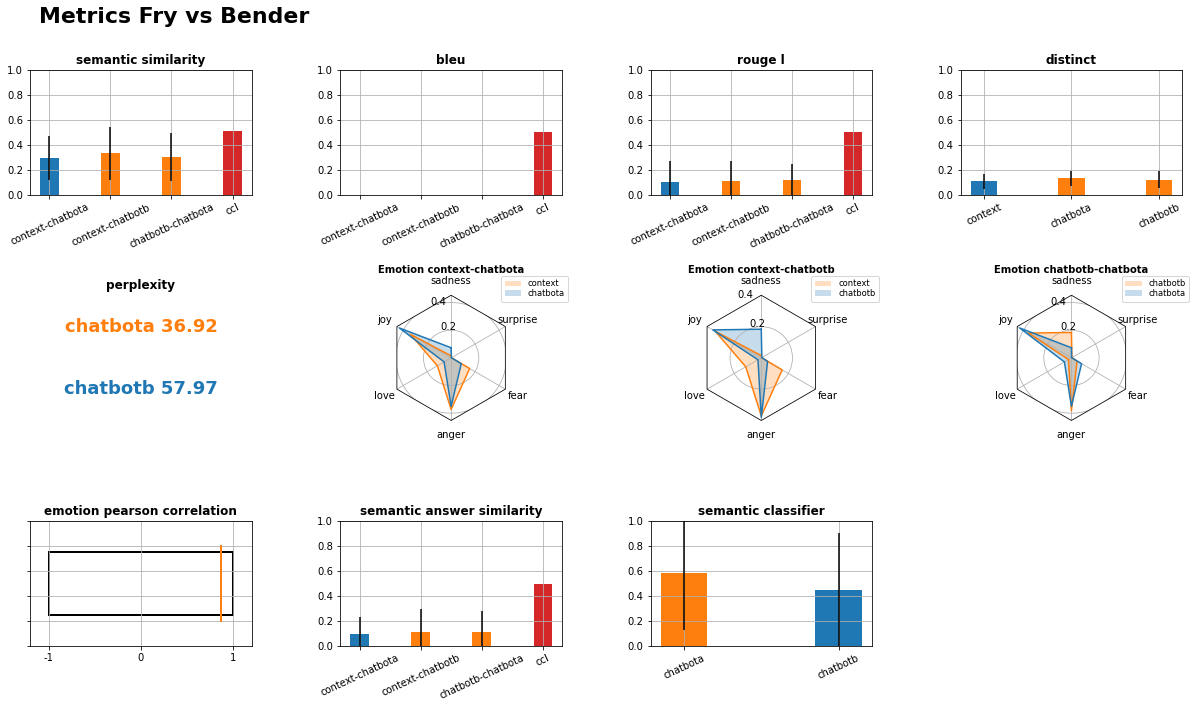

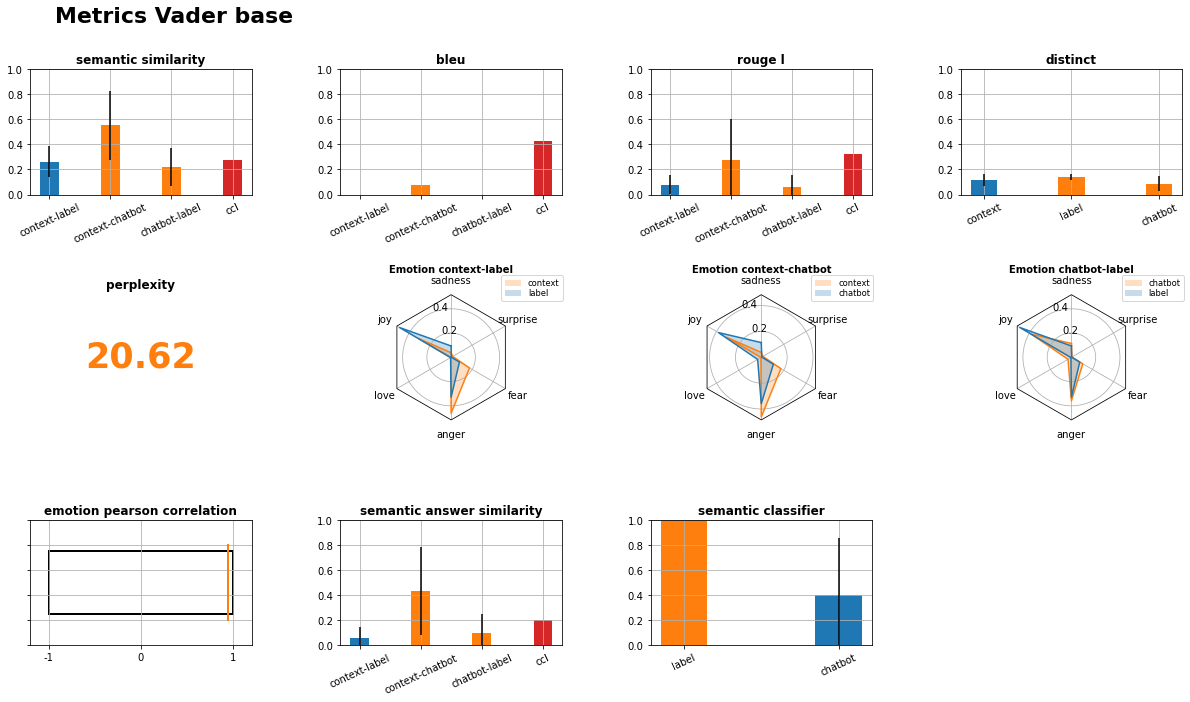

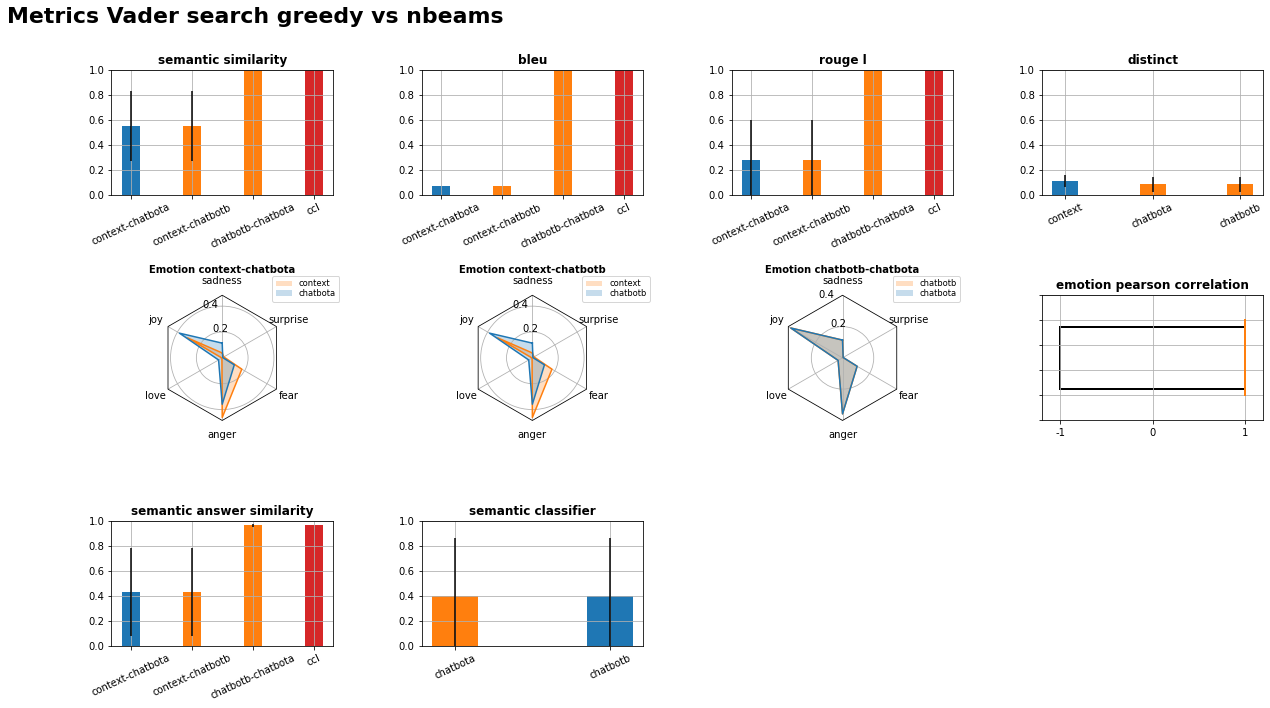

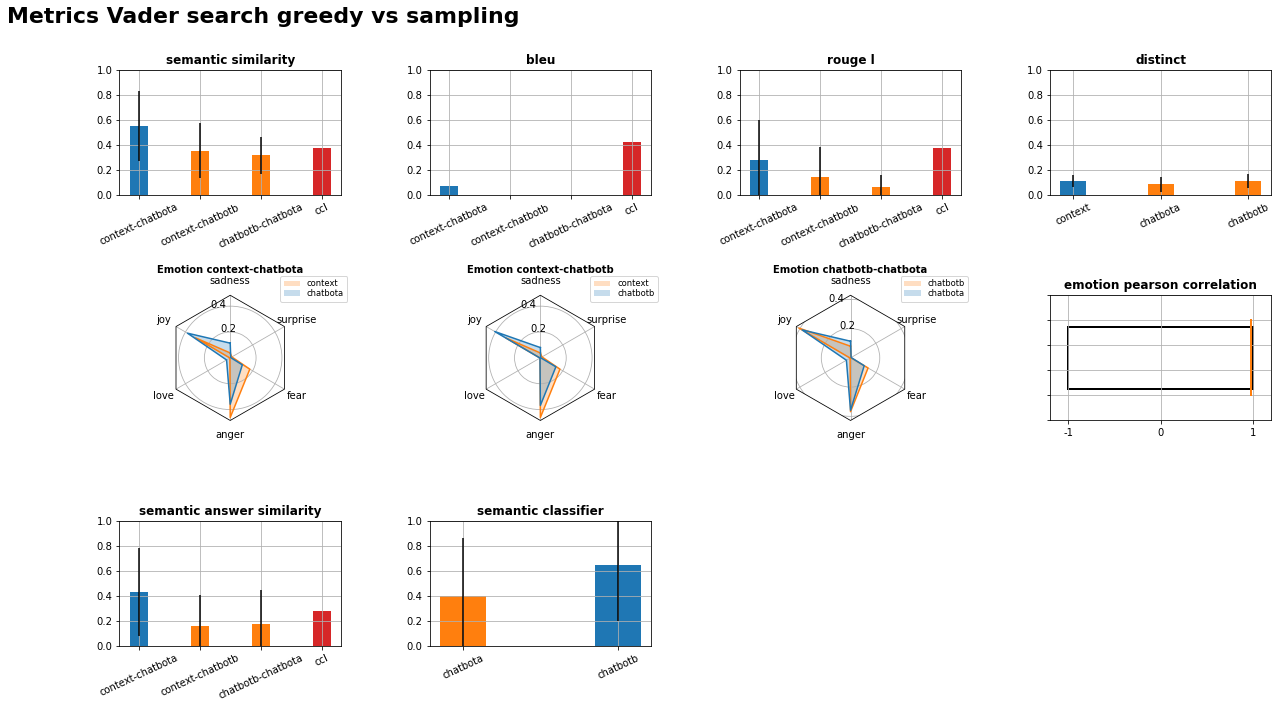

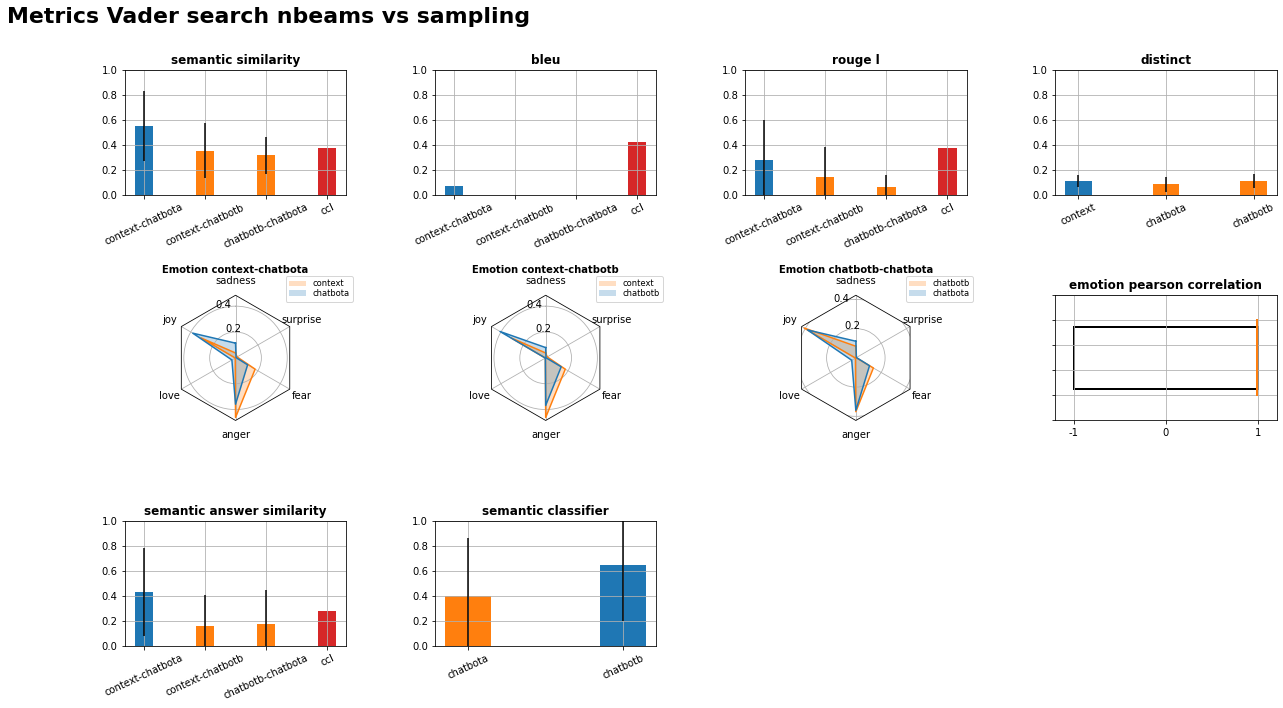

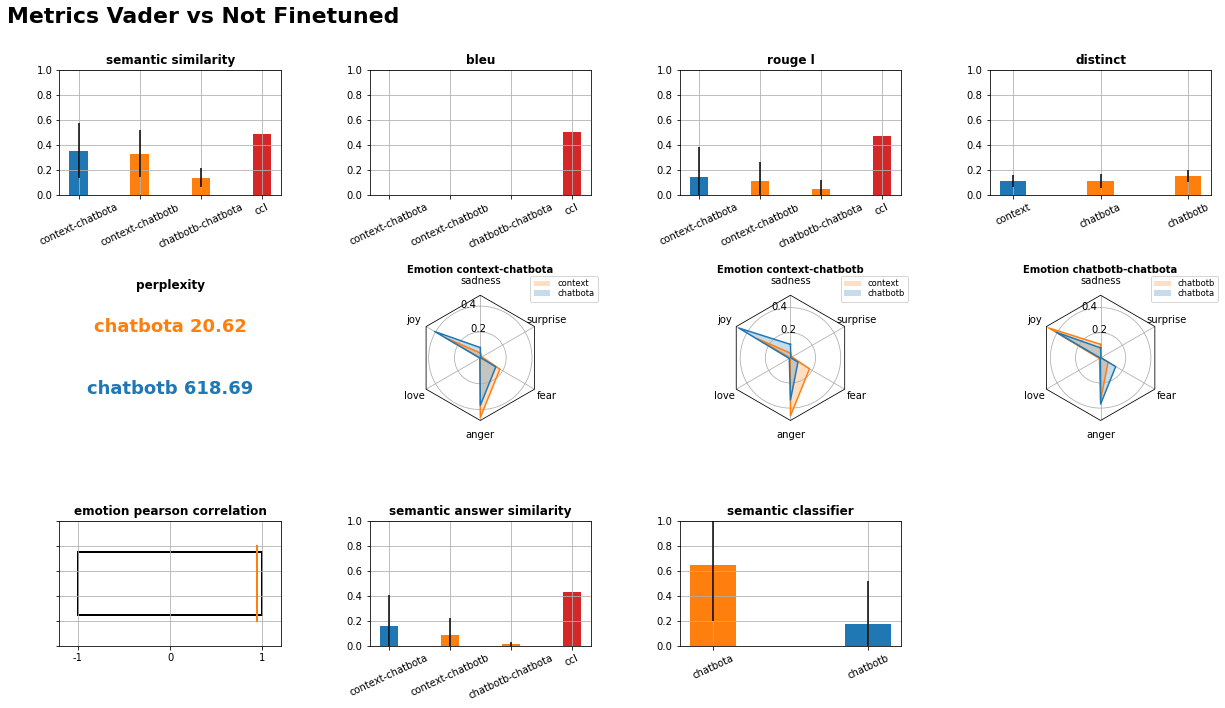

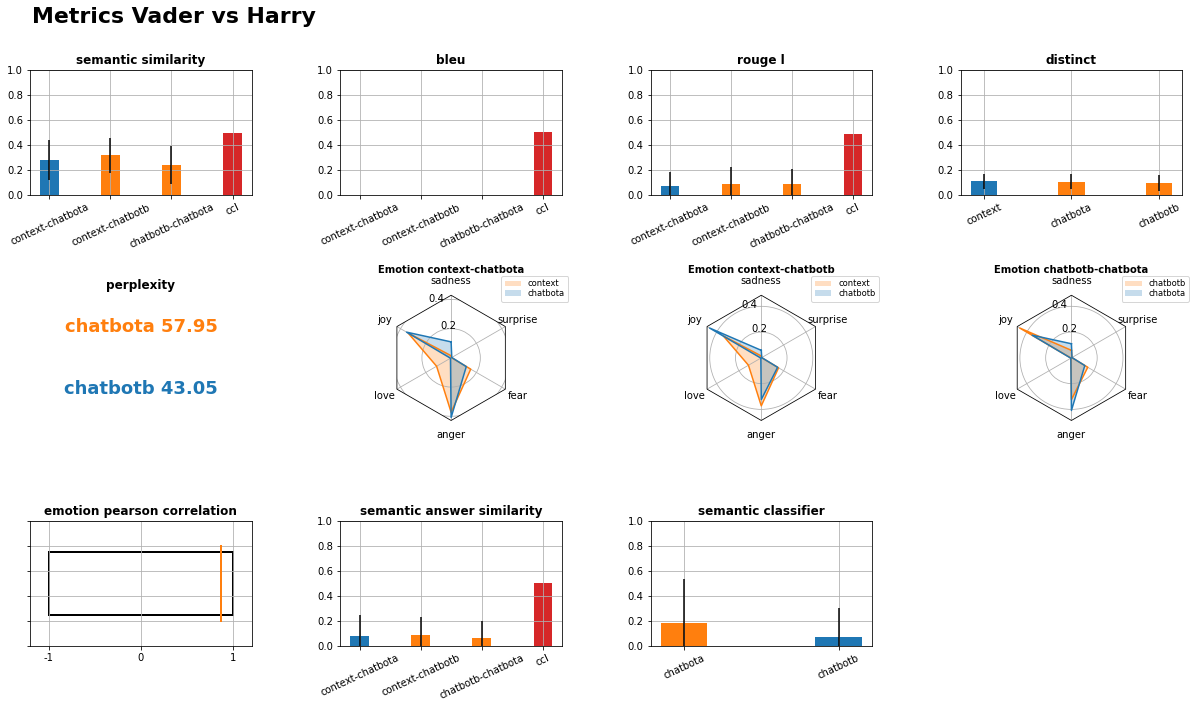

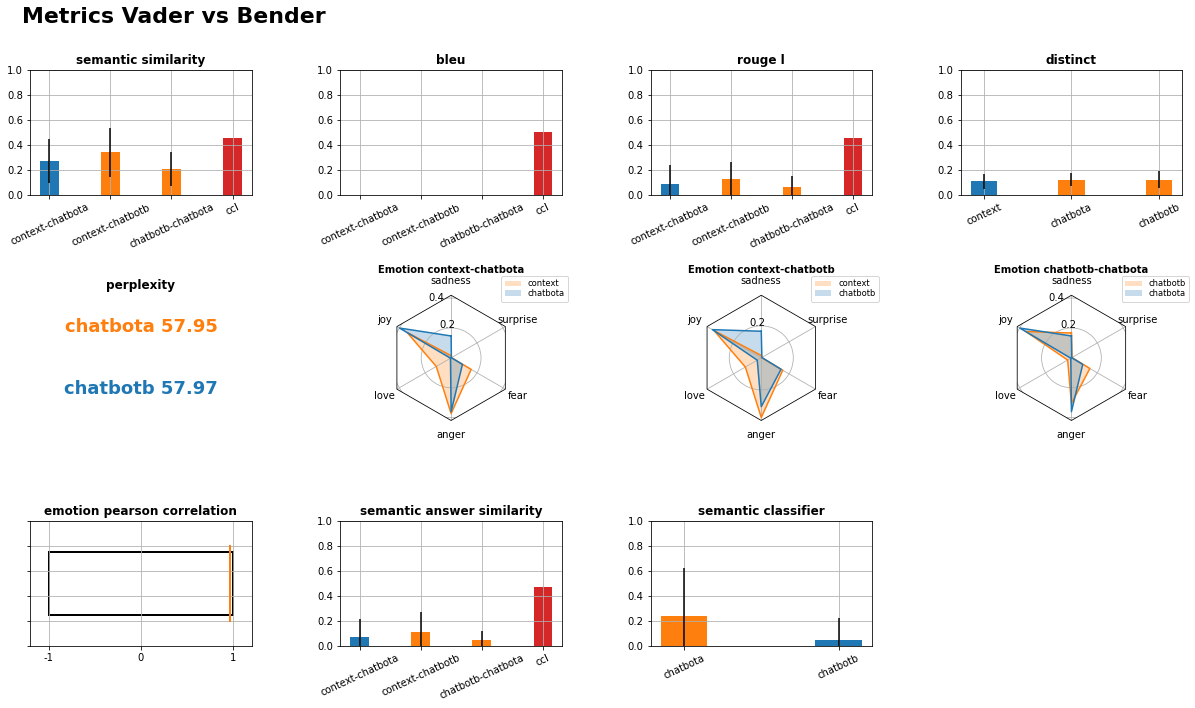

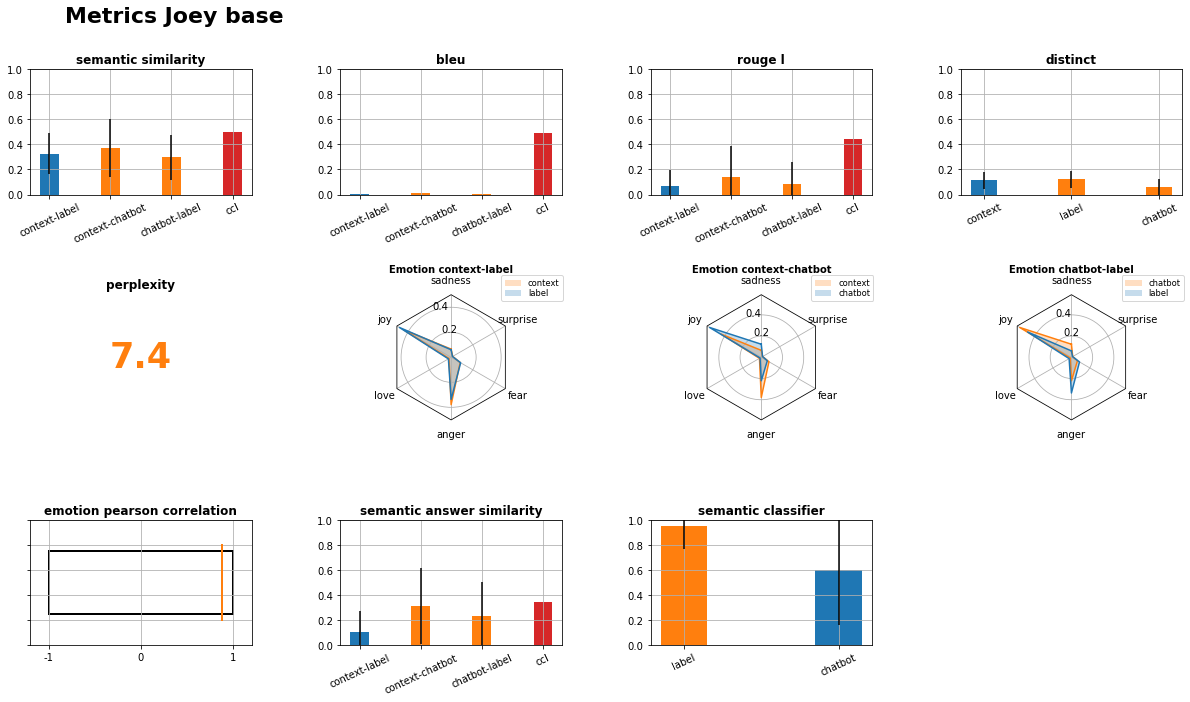

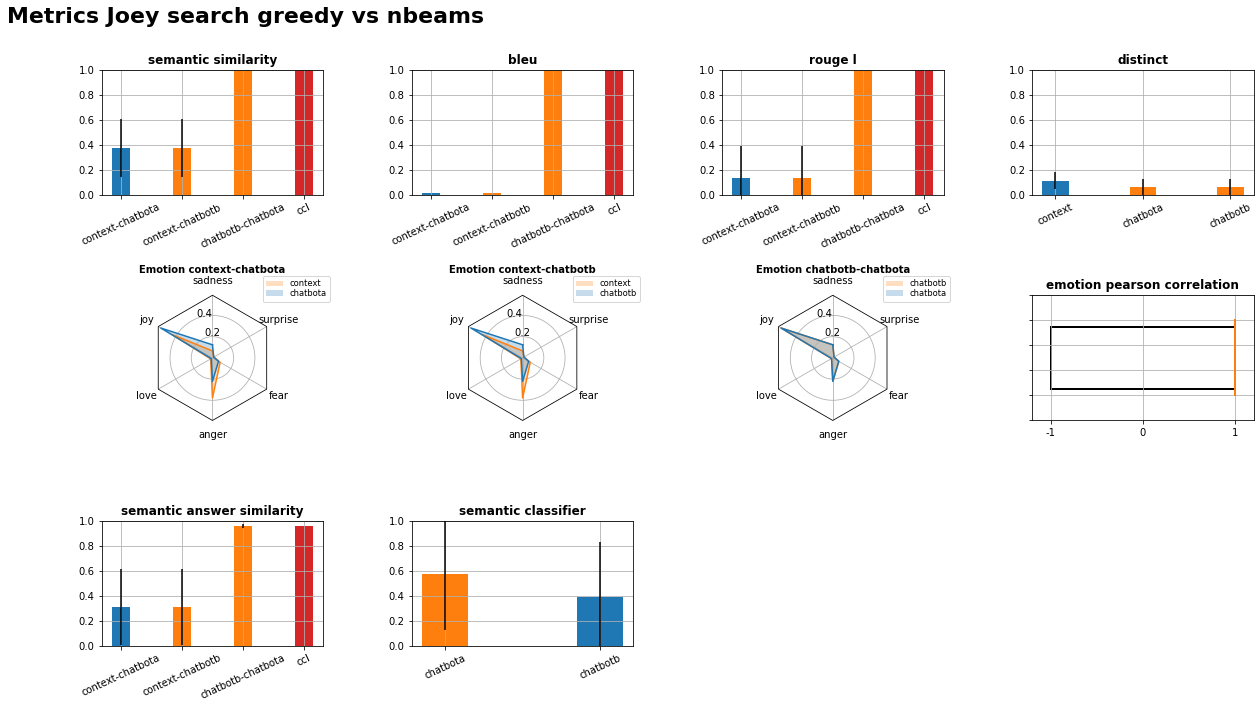

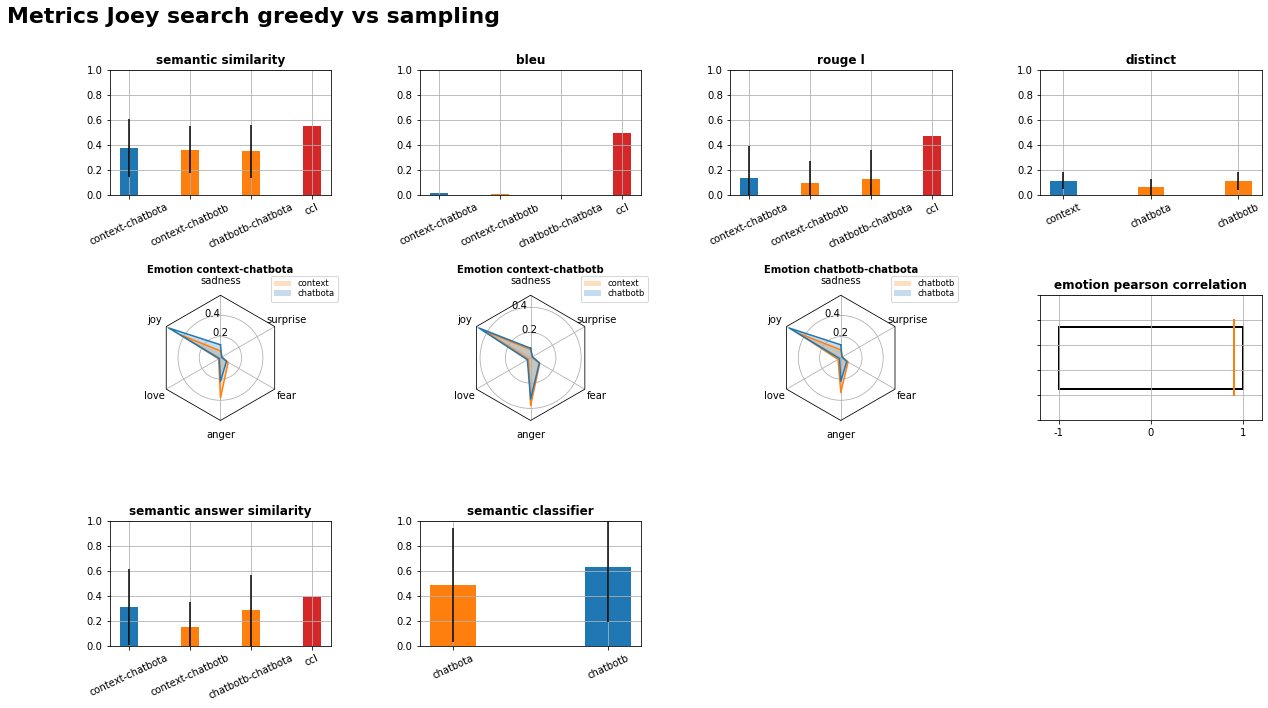

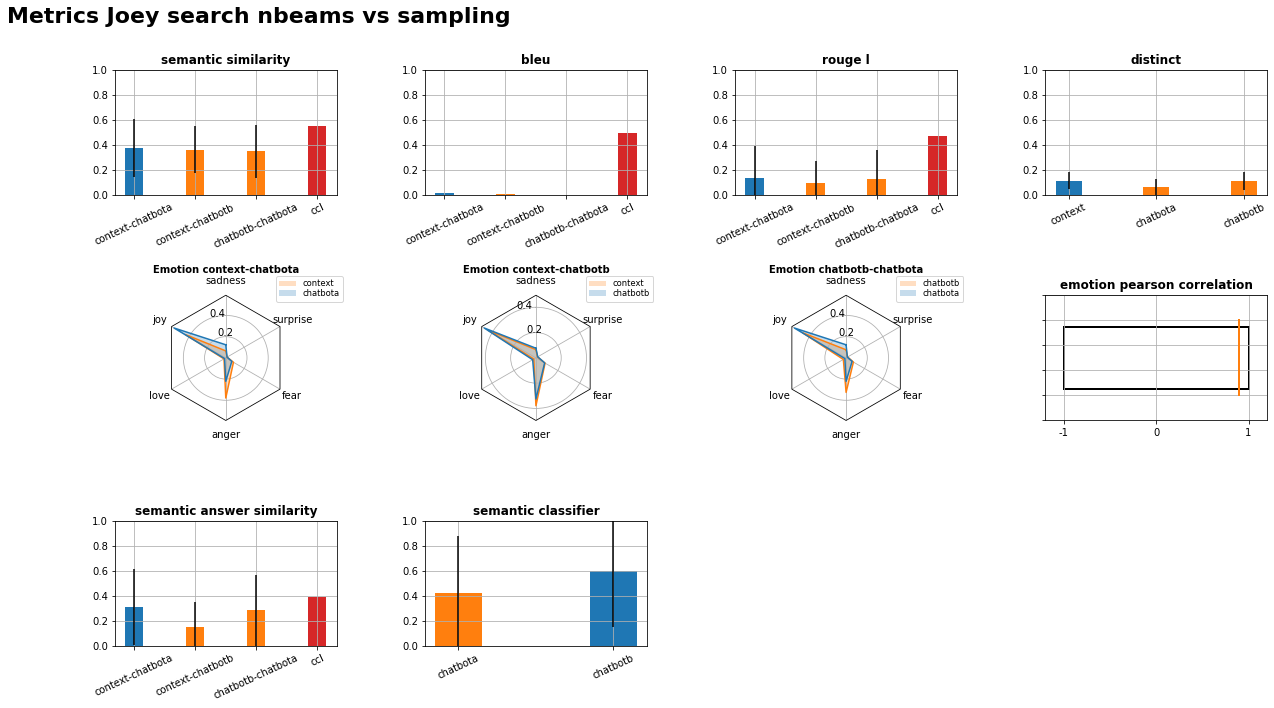

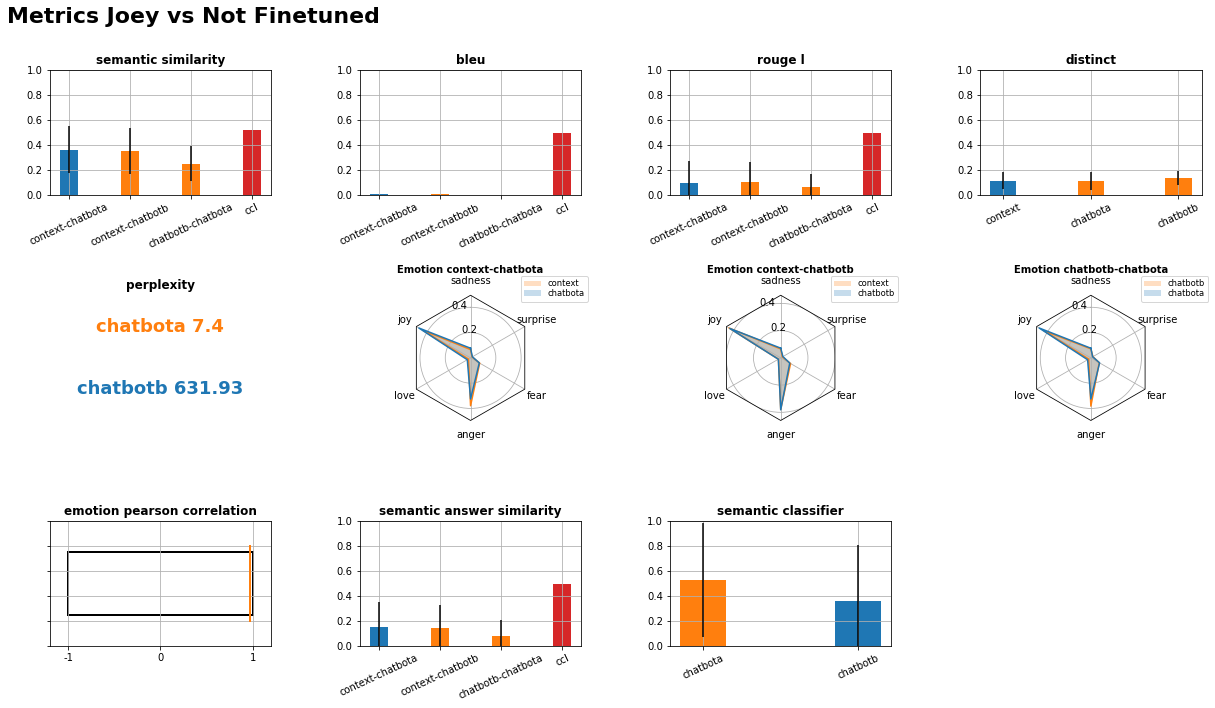

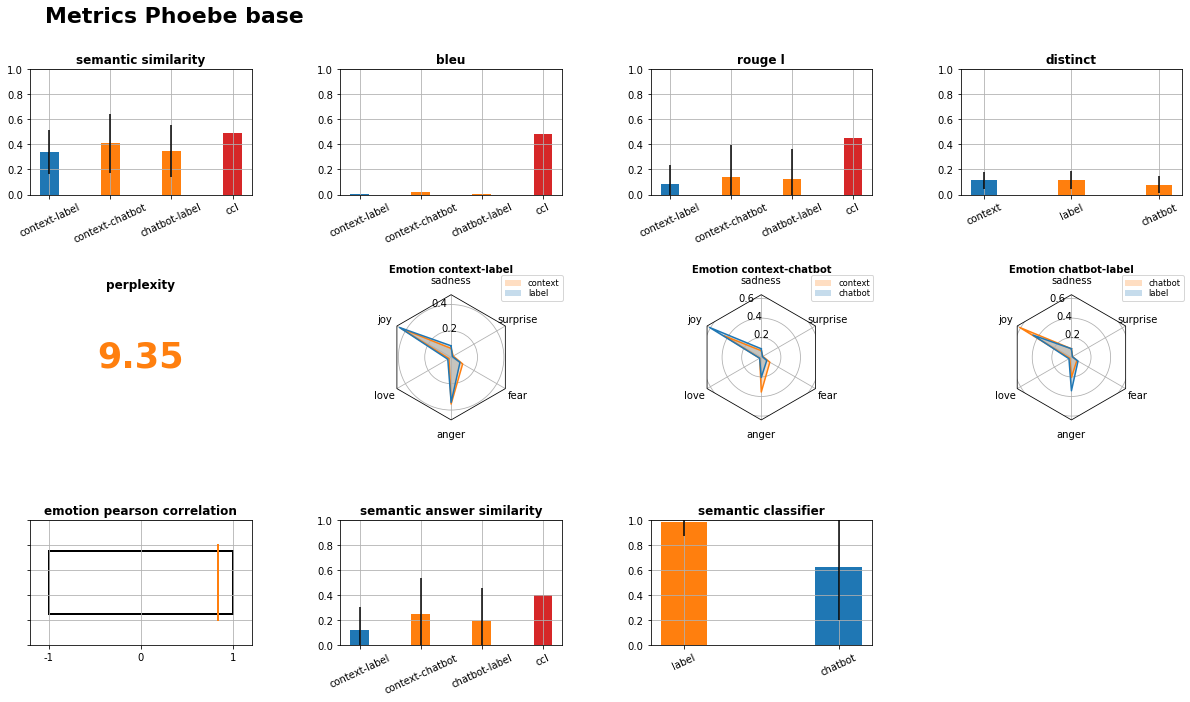

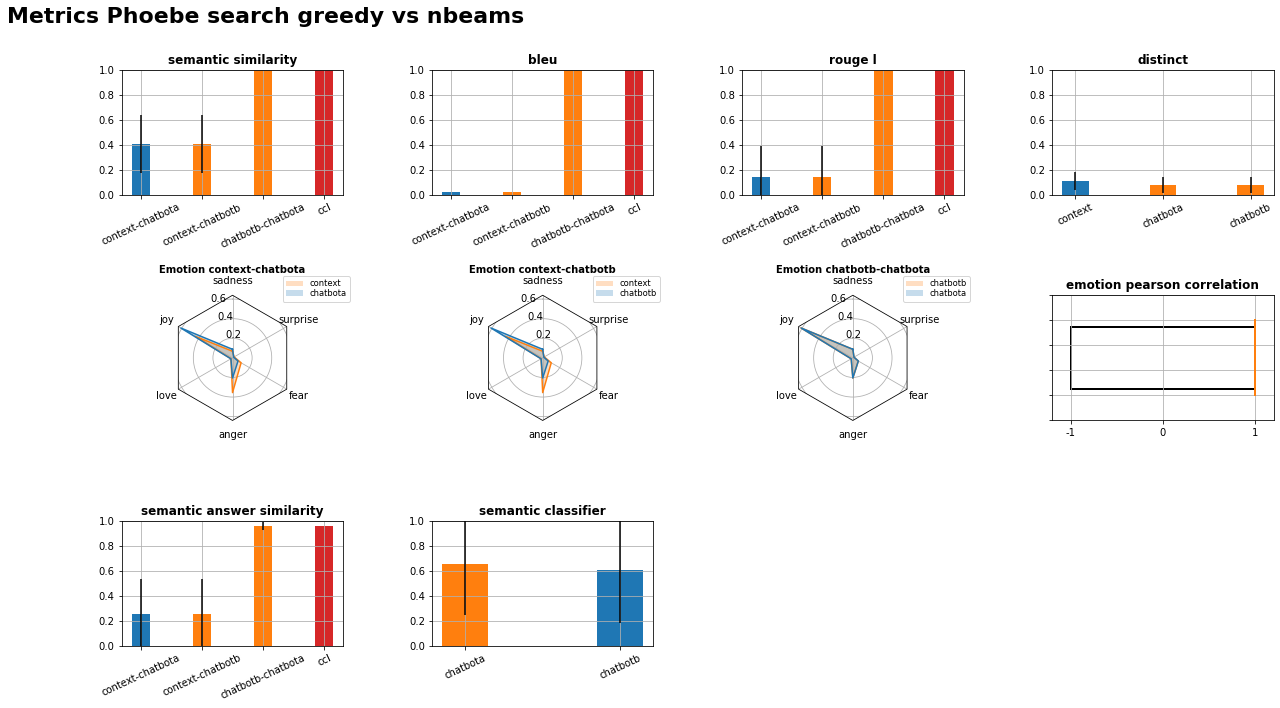

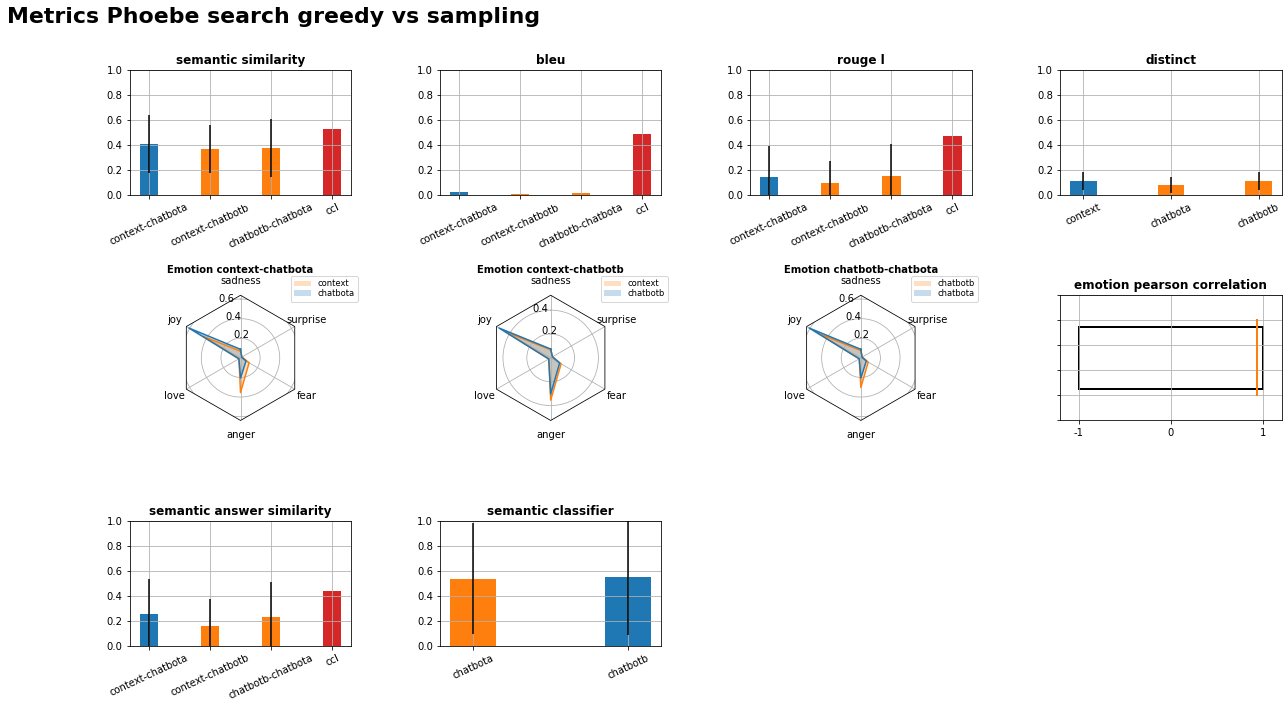

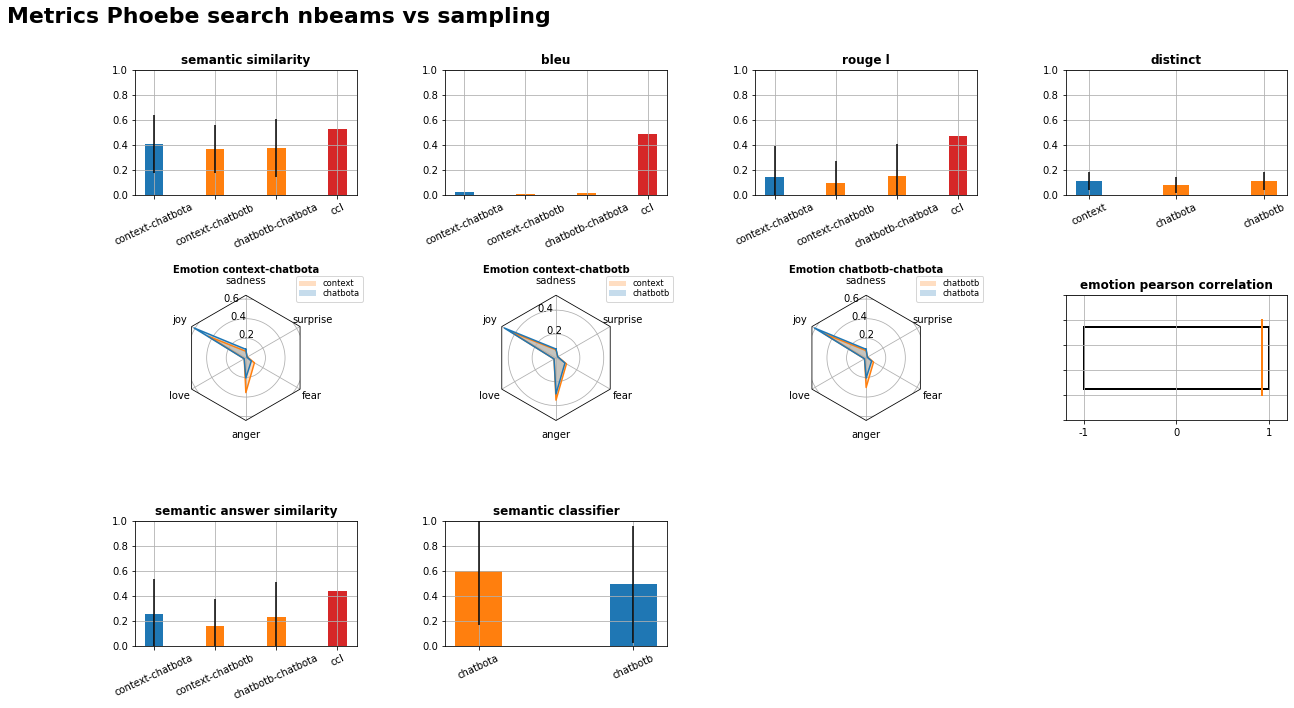

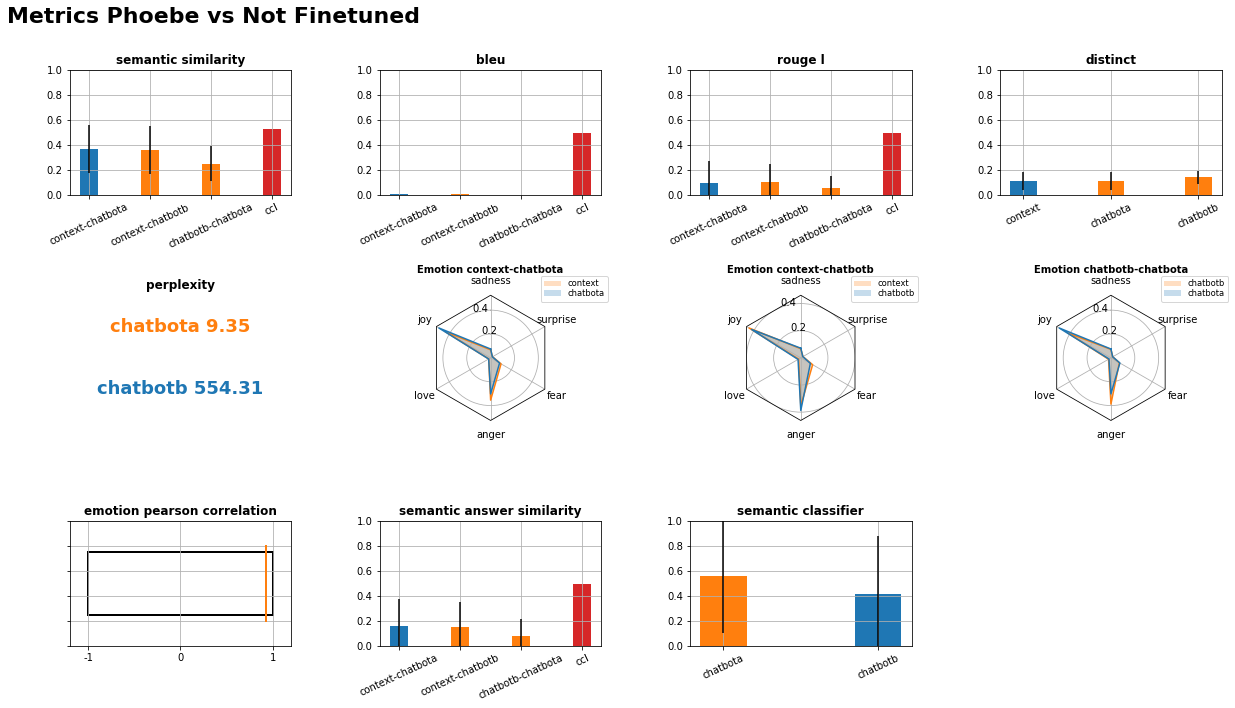

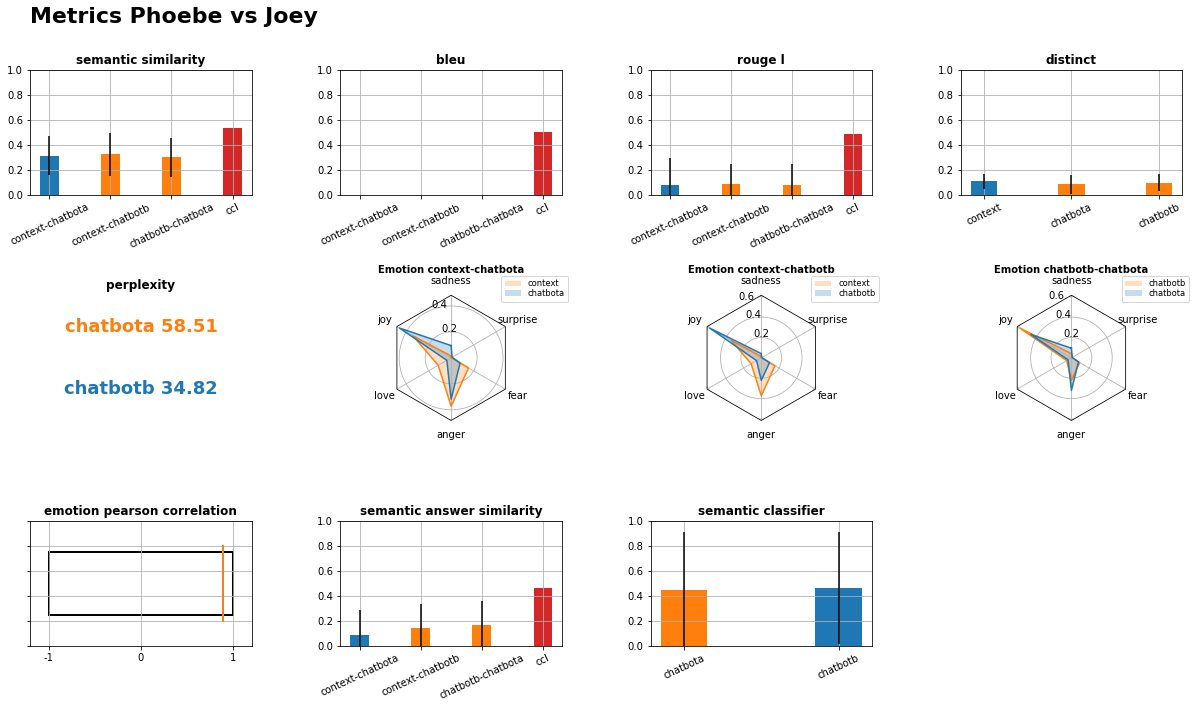

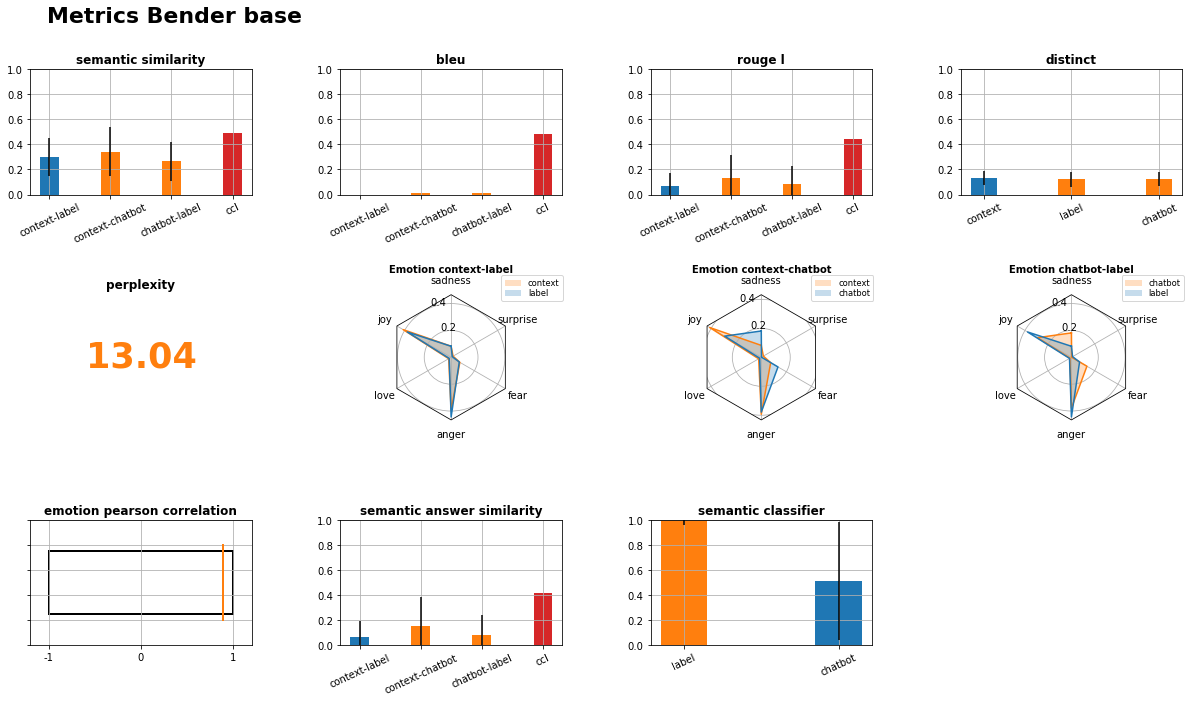

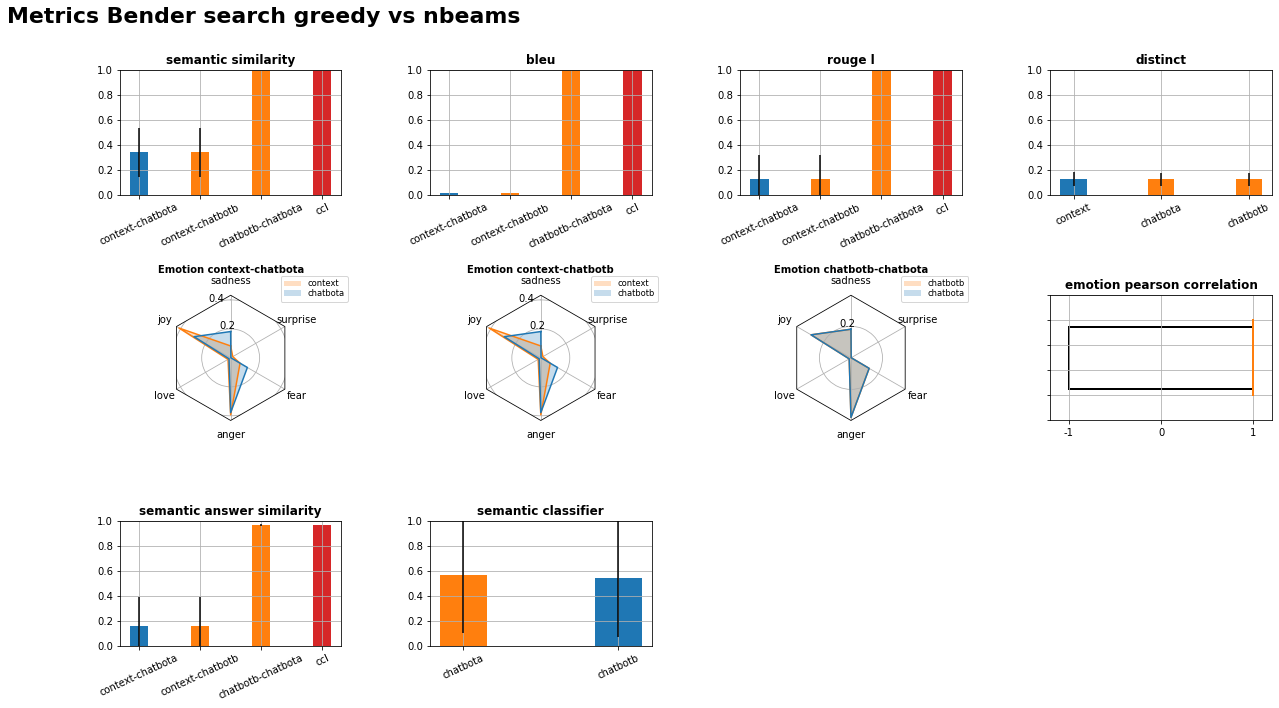

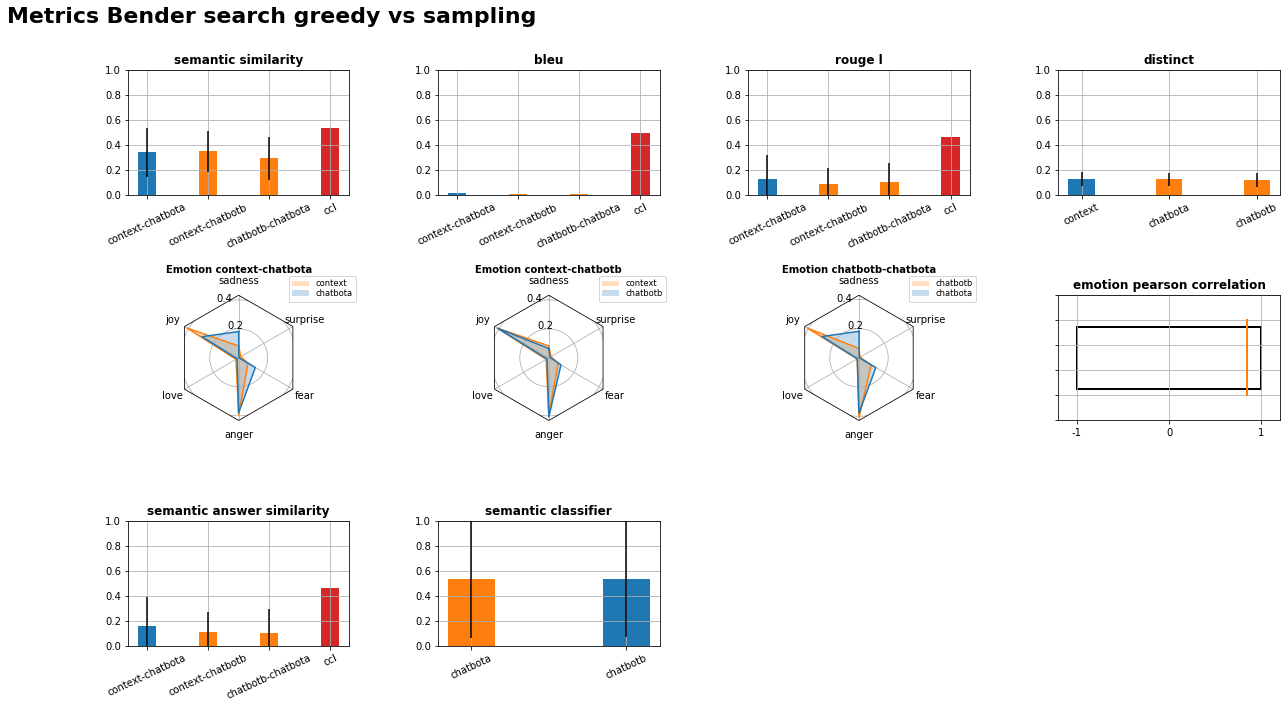

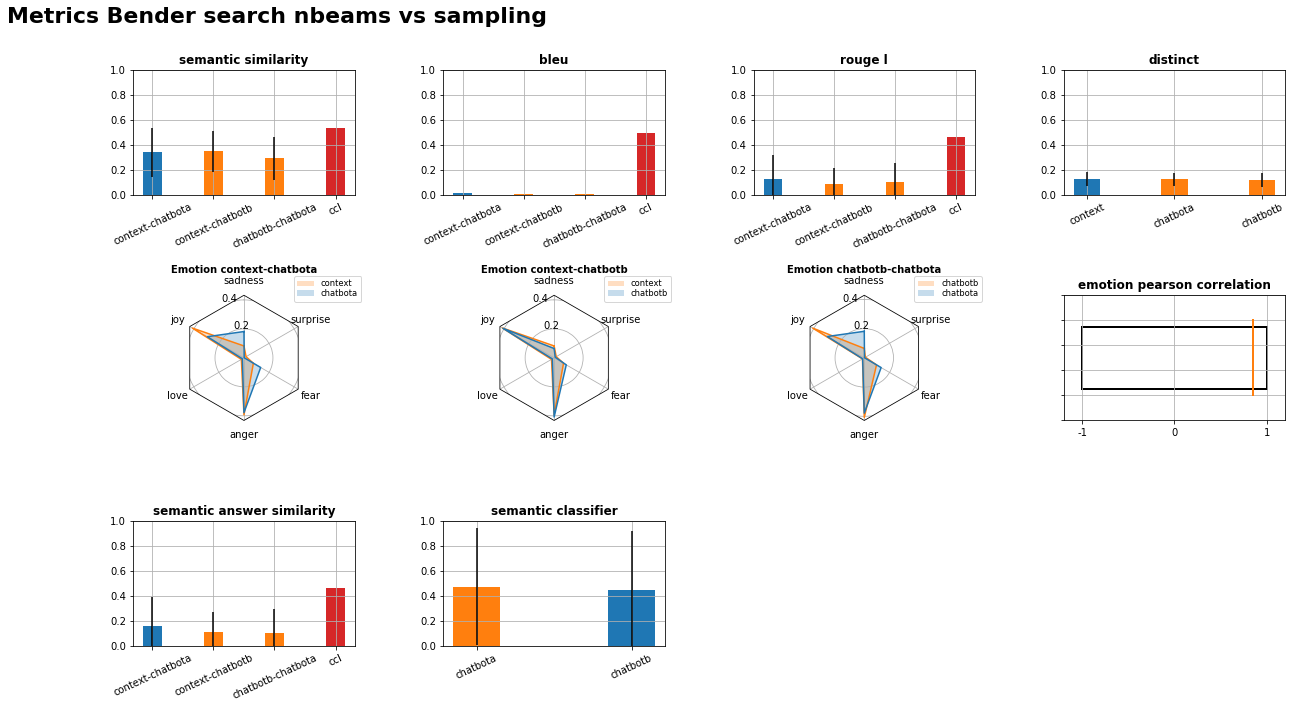

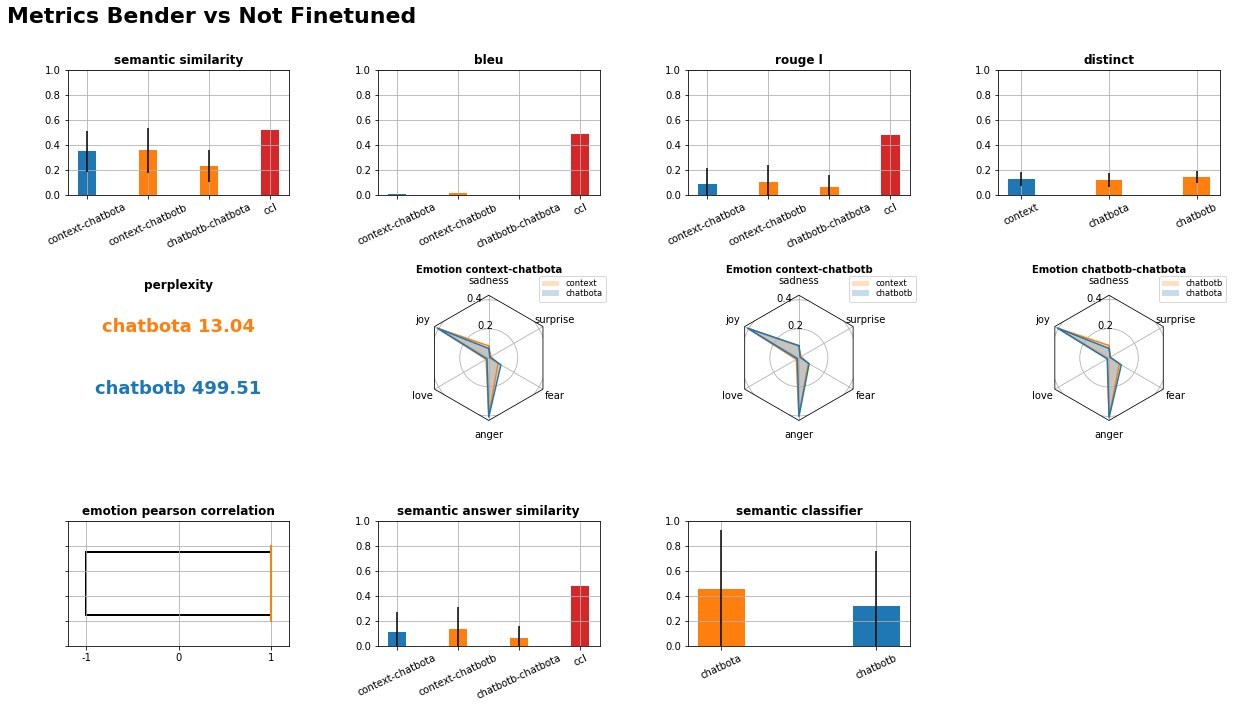

In [26]:
plotMetricsChars(characters)